#### MVP Machine Learning & Analytics

**Nome:** Fabiano da Mata Almeida<br>
**Matrícula:** 4052025000952<br>
**Dataset:** Pressão de Vapor da nafta.

**Nota sobre confidencialidade e descaracterização dos dados:**  
> Para garantir a confidencialidade e o respeito à privacidade, todos os dados utilizados neste estudo foram devidamente descaracterizados, não permitindo a identificação na sua unidade de medida original ou informações sensíveis.<br>
O uso desse dataset segue as boas práticas de ética em ciência de dados, assegurando que nenhuma informação pessoal ou confidencial seja exposta durante as análises.

# 1. Escopo, Objetivo e Definição do Problema

## 1.1. Contexto do problema e objetivo

O conjunto de dados **Pressão de Vapor da Nafta** contempla observações de uma corrente do processo de fracionamento do petróleo, contendo variáveis físico-químicas do processo e propriedades da corrente.

A variável alvo representa a pressão exercida pelo vapor em equilíbrio com sua fase líquida a uma temperatura específica. Essa propriedade caracteriza a volatilidade da corrente, impactando requisitos de armazenamento, segurança, transporte e conformidade regulatória.

**Objetivo:** Desenvolver um modelo preditivo para estimar a pressão de vapor da nafta com precisão, permitindo operação próxima ao limite superior da especificação sem comprometer a segurança.

*Nota: O conjunto de dados foi previamente analisado na SPRINT de Análise de Dados e Boas Práticas, permitindo EDA simplificada.*

## 1.2. Tipo de tarefa

Estudo de **regressão** com dados tabulares originados de sensores industriais e ensaios laboratoriais, aplicado à engenharia de processos na formulação de gasolina automotiva.

A tarefa envolve desenvolvimento de modelo supervisionado para predição contínua de propriedade físico-química crítica.

## 1.3. Valor para o negócio/usuário

**Ganho econômico:** A predição confiável permite incorporar frações mais pesadas do GLP à nafta, agregando valor significativo (GLP vale ~50% da gasolina por volume).

**Aplicações operacionais:**
- Otimização de parâmetros operacionais em tempo real
- Integração em sistemas de controle preditivo multivariável (MPC)
- Automação da gestão da propriedade

**Beneficiários:** Engenharia de Processos, Operações Industriais e Segurança Operacional, através de maior eficiência, previsibilidade e controle de qualidade.


# 2. Reprodutibilidade e ambiente

Esta seção consolida todas as importações de bibliotecas necessárias, definições das funções utilizadas e algumas configurações iniciais globais.

In [ ]:
# Bibliotecas básicas
import time, sys, joblib, math, os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import seaborn as sns

# Visualização
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate

# Análise estatística
from scipy.stats import norm, kstest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_objective
from skopt.callbacks import VerboseCallback, CheckpointSaver

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.options.display.float_format = '{:.4f}'.format  # Define o formato de exibição dos números float no pandas para quatro casas decimais
pd.set_option('display.expand_frame_repr', False)  # Não quebra a representação do dataframe
np.set_printoptions(precision=8, suppress=True, floatmode='maxprec') # Define o formato de exibição dos números float no numpy para oito casas decimais e sem notação científica


In [ ]:
# import inspect

# reg = LGBMRegressor()
# sig = inspect.signature(reg.fit)
# supported = set(sig.parameters.keys())

## 2.1 Dependências
Eventual instalação de pacotes extras. <br>
*Manter o projeto enxuto*.

In [ ]:
# Exemplo: descomente o que precisar
# !pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna
# !pip install -q pandas-profiling ydata-profiling
# !pip install -q matplotlib seaborn plotly
# !pip install -q statsmodels pmdarima

## 2.2. Funções e Classes python
Definição de funções em Python. <br>
*Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.*

In [ ]:
class MetricsMonitorCallback:
    """
    Callback para monitorar métricas durante a otimização bayesiana,
    detectar overfitting e gerar visualizações.
    """
    def __init__(self, model_name, scaler_name, metric, threshold=0.2, 
                 plot_interval=5, plot_dir='optimization_plots'):
        """
        Inicializa o callback para monitoramento de métricas.
        
        Args:
            model_name (str): Nome do modelo sendo otimizado
            scaler_name (str): Nome do scaler utilizado
            metric (str): Nome da métrica principal a ser monitorada
            threshold (float): Limiar para detecção de overfitting (diferença entre treino e validação)
            plot_interval (int): Intervalo de iterações para gerar gráficos
            plot_dir (str): Diretório para salvar os gráficos
        """
        self.model_name = model_name
        self.scaler_name = scaler_name
        self.metric = metric
        self.threshold = threshold
        self.plot_interval = plot_interval
        self.plot_dir = plot_dir
        self.bayes_search = None
        self.iteration = 0
        self.train_scores = []
        self.val_scores = []
        self.params_history = []
        self.overfitting_detected = False
        self.is_higher_better = metric in ['r2']
        
        # Criar diretório para os gráficos se não existir
        os.makedirs(plot_dir, exist_ok=True)
        
        # Timestamp para identificar a execução
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    def __call__(self, res):
        """
        Método chamado a cada iteração da busca bayesiana.
        
        Args:
            res: Resultado atual da otimização
        """
        self.iteration += 1
        
        # Acessar os resultados diretamente do objeto res
        # Em vez de depender do cv_results_ do BayesSearchCV
        try:
            # Extrair informações do resultado atual
            if hasattr(res, 'func_vals'):
                # res.func_vals contém os valores negativos da métrica sendo otimizada
                # (skopt sempre minimiza, então métricas como accuracy são negadas)
                current_val_score = -res.func_vals[-1] if len(res.func_vals) > 0 else None
                
                # Extrair os parâmetros desta iteração
                current_params = {}
                if hasattr(res, 'x_iters') and len(res.x_iters) > 0:
                    # Os parâmetros da iteração atual estão em x_iters[-1]
                    param_values = res.x_iters[-1]
                    
                    # Se tivermos acesso ao BayesSearchCV, podemos obter os nomes dos parâmetros
                    if self.bayes_search is not None and hasattr(self.bayes_search, 'search_spaces_'):
                        param_names = list(self.bayes_search.search_spaces_.keys())
                        for i, name in enumerate(param_names):
                            if i < len(param_values):
                                current_params[name] = param_values[i]
                
                # Como não temos acesso direto ao train_score durante a otimização,
                # vamos estimar usando um valor fictício ou deixar como None
                current_train_score = None
                
                # Adicionar os valores às listas
                if current_val_score is not None:
                    self.val_scores.append(current_val_score)
                    # Adicionar um placeholder para o train_score
                    # Será atualizado no final quando tivermos acesso ao cv_results_
                    self.train_scores.append(current_train_score)
                    self.params_history.append(current_params)
                
                # Imprimir progresso
                print(f"\nIteração {self.iteration}: {self.model_name} + {self.scaler_name}")
                print(f"   Validação estimada {self.metric}: {current_val_score:.4f}")
                
                # # Gerar gráfico a cada plot_interval iterações
                # if self.iteration % self.plot_interval == 0:
                #     self._plot_progress()
        
        except Exception as e:
            print(f"Erro ao processar resultados da iteração {self.iteration}: {str(e)}")
    
    def finalize(self):
        """
        Método a ser chamado após a conclusão da otimização para
        atualizar as métricas com os valores reais de cv_results_
        """
        if self.bayes_search is None or not hasattr(self.bayes_search, 'cv_results_'):
            print("Aviso: Não foi possível acessar cv_results_ para finalização.")
            return
        
        try:
            cv_results = self.bayes_search.cv_results_
            train_key = f'mean_train_{self.metric}'
            test_key = f'mean_test_{self.metric}'
            
            if train_key in cv_results and test_key in cv_results:
                # Atualizar as métricas com os valores reais
                self.train_scores = list(cv_results[train_key])
                self.val_scores = list(cv_results[test_key])
                
                # Atualizar os parâmetros
                self.params_history = cv_results['params']
                
                # Gerar um gráfico final
                self._plot_progress(final=True)
                
                # Verificar overfitting em todas as iterações
                for i in range(len(self.train_scores)):
                    train_score = self.train_scores[i]
                    val_score = self.val_scores[i]
                    diff = abs(train_score - val_score)
                    is_overfitting = diff > self.threshold * max(abs(train_score), abs(val_score))
                    
                    if is_overfitting:
                        print(f"\n⚠️ ALERTA: Possível overfitting detectado na iteração {i+1}!")
                        print(f"   Treino: {train_score:.4f}, Validação: {val_score:.4f}, Diferença: {diff:.4f}")
        
        except Exception as e:
            print(f"Erro ao finalizar métricas: {str(e)}")
    
    def _plot_progress(self, final=False):
        """
        Gera e salva gráficos de progresso das métricas.
        
        Args:
            final (bool): Indica se este é o gráfico final com dados completos
        """
        if len(self.val_scores) < 2:
            return  # Precisamos de pelo menos dois pontos para plotar
        
        plt.figure(figsize=(12, 8))
        
        # Plot das métricas
        plt.subplot(2, 1, 1)
        iterations = list(range(1, len(self.val_scores) + 1))
        
        # Plotar scores de validação
        plt.plot(iterations, self.val_scores, 'r-', label=f'Validação {self.metric}')
        
        # Plotar scores de treino se disponíveis (geralmente apenas no gráfico final)
        if final and all(score is not None for score in self.train_scores):
            plt.plot(iterations, self.train_scores, 'b-', label=f'Treino {self.metric}')
        
        title = f'Progresso da Otimização: {self.model_name} + {self.scaler_name}'
        if final:
            title += ' (Final)'
        plt.title(title)
        plt.xlabel('Iteração')
        plt.ylabel(self.metric)
        plt.legend()
        plt.grid(True)
        
        # Plot da diferença (para detectar overfitting) - apenas no gráfico final
        plt.subplot(2, 1, 2)
        if final and all(score is not None for score in self.train_scores):
            diff = [abs(t - v) for t, v in zip(self.train_scores, self.val_scores)]
            plt.plot(iterations, diff, 'g-', label='|Treino - Validação|')
            plt.axhline(y=self.threshold * np.mean(np.abs(self.val_scores)), 
                       color='r', linestyle='--', 
                       label=f'Limiar de Overfitting ({self.threshold:.2f})')
        else:
            # Durante a otimização, apenas mostrar o progresso da validação
            plt.plot(iterations, self.val_scores, 'r-', label=f'Validação {self.metric} (Progresso)')
        
        plt.xlabel('Iteração')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        
        # Salvar o gráfico
        suffix = "_final" if final else f"_iter{self.iteration}"
        filename = f"{self.plot_dir}/{self.model_name}_{self.scaler_name}_{self.timestamp}{suffix}.png"
        plt.savefig(filename)
        plt.close()
        
        # Também salvar os dados em CSV para análise posterior
        # self._save_metrics_to_csv(final)
    
    def _save_metrics_to_csv(self, final=False):
        """
        Salva as métricas e parâmetros em um arquivo CSV.
        
        Args:
            final (bool): Indica se este é o CSV final com dados completos
        """
        data = {
            'iteration': list(range(1, len(self.val_scores) + 1)),
            f'val_{self.metric}': self.val_scores
        }
        
        # Adicionar train_scores apenas se forem válidos
        if final and all(score is not None for score in self.train_scores):
            data[f'train_{self.metric}'] = self.train_scores
            data['diff'] = [abs(t - v) for t, v in zip(self.train_scores, self.val_scores)]
        
        # Adicionar os parâmetros para cada iteração
        for i, params in enumerate(self.params_history):
            for key, value in params.items():
                if key not in data:
                    data[key] = [None] * len(self.val_scores)
                if i < len(self.val_scores):  # Garantir que não ultrapasse o tamanho da lista
                    data[key][i] = value
        
        # Salvar o CSV
        suffix = "_final" if final else f"_iter{self.iteration}"
        filename = f"{self.plot_dir}/{self.model_name}_{self.scaler_name}_{self.timestamp}{suffix}.csv"
        pd.DataFrame(data).to_csv(filename, index=False)

In [ ]:
# Declaração de funções


def teste_n(df, column_name, alpha=0.05):
    """
    Executa o teste de Kolmogorov-Smirnov para verificar se uma coluna do DataFrame segue uma distribuição normal.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    column_name : str
        Nome da coluna a ser testada quanto à normalidade.
    alpha : float, opcional
        Nível de significância para o teste. O padrão é 0.05 (5%).

    Descrição:
    ----------
    - Normaliza os dados da coluna (subtrai a média e divide pelo desvio padrão).
    - Aplica o teste de Kolmogorov-Smirnov comparando com uma distribuição normal padrão.
    - Interpreta os resultados com base no p-valor e o nível de significância especificado.
    - Exibe uma mensagem informando se a distribuição pode ser considerada normal ou não.

    Retorno:
    --------
    tuple
        Uma tupla contendo (estatística do teste, p-valor).

    Exemplo de uso:
    --------------
    stat, p_valor = teste_n(df, 'pv_nafta')
    stat, p_valor = teste_n(df, 'pv_nafta', alpha=0.01)  # Usando significância de 1%
    """
    # Executar o teste de Kolmogorov-Smirnov - nesse caso em relação a uma distribuição normal
    stat, p_valor = kstest((df[column_name] - np.mean(df[column_name])) / np.std(df[column_name], ddof=1), 'norm')

    # Interpretar os resultados
    if p_valor > alpha:
        print("A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor:", f"{p_valor:.5f}")
    else:
        print("A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor:", f"{p_valor:.5f}")
    return float(stat), float(p_valor)

def calcula_corr(df):
    """
    Calcula e visualiza a matriz de correlação absoluta entre as variáveis de um DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados para cálculo da correlação.

    Descrição:
    ----------
    - Remove valores NaN do DataFrame antes de calcular as correlações.
    - Calcula a matriz de correlação absoluta entre todas as variáveis.
    - Cria uma visualização interativa usando Plotly Express.
    - Aplica uma escala de cores Viridis para representar a intensidade das correlações.
    - Mostra os valores numéricos das correlações com duas casas decimais.

    Exemplo de uso:
    --------------
    calcula_corr(df)
    calcula_corr(df[selected_columns])  # Para um subconjunto de colunas
    """
    df_corr = df.dropna().corr().abs()

    fig = px.imshow(
        img    = df_corr,
        color_continuous_scale='Viridis',
        width  = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        height = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        text_auto = ".2f"  # Mostra os valores com 2 casas decimais
    )

    fig.update_traces(textfont_size=12)  # Altere o valor conforme desejado
    fig.show()

def pairplot_corr_hm(df, figsize=(12, 12), hist_bins=30, s=10, alpha=0.6):
    """
    Cria um pairplot onde a cor dos pontos é baseada na correlação absoluta entre variáveis
    usando uma paleta de cores Viridis.

    Parâmetros:
    -----------
    df : pandas DataFrame
        O DataFrame contendo os dados a serem plotados
    figsize : tuple, opcional
        Tamanho da figura (largura, altura) em polegadas
    hist_bins : int, opcional
        Número de bins para os histogramas na diagonal
    s : int, opcional
        Tamanho dos pontos nos gráficos de dispersão
    alpha : float, opcional
        Nível de transparência dos pontos (0-1)
    """

    # Obter a matriz de correlação absoluta
    corr_matrix = df.corr().abs()

    # Configurar a normalização de cores para a escala viridis
    norm = Normalize(vmin=0, vmax=1)

    # Obter as variáveis e o número de variáveis
    variables = df.columns
    n_vars = len(variables)

    # Criar a figura e os subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    # Ajustar o espaçamento entre os subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Criar os gráficos para cada par de variáveis
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            ax = axes[i, j]

            # Remover os ticks dos eixos internos
            if i < n_vars - 1:
                ax.set_xticks([])
            if j > 0:
                ax.set_yticks([])

            # Se estamos na diagonal, plotar histograma
            if i == j:
                ax.hist(df[var1], bins=hist_bins, alpha=0.7, color='darkblue')
                ax.set_title(var1, fontsize=10)
            else:
                # Obter a correlação absoluta entre as variáveis
                corr_val = corr_matrix.loc[var1, var2]

                # Determinar a cor com base na correlação
                color = viridis(norm(corr_val))

                # Criar o gráfico de dispersão
                ax.scatter(df[var2], df[var1], s=s, alpha=alpha, color=color)

                # Adicionar a correlação como texto no gráfico
                ax.text(0.05, 0.95, f'|ρ|: {corr_val:.2f}',
                        transform=ax.transAxes, fontsize=8,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Adicionar os nomes das variáveis apenas nos eixos externos
    for i, var in enumerate(variables):
        axes[n_vars-1, i].set_xlabel(var, fontsize=10)
        axes[i, 0].set_ylabel(var, fontsize=10)

    # Adicionar uma barra de cores para referência
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax)
    cb.set_label('Correlação Absoluta |ρ|')

    plt.suptitle('Pairplot com Cores Baseadas na Correlação Absoluta', fontsize=16)
    plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)

def calcula_vif(df,target):
    """
    Calcula o Fator de Inflação da Variância (VIF) para identificar multicolinearidade em variáveis.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo apenas as variáveis independentes para as quais se deseja calcular o VIF.

    Descrição:
    ----------
    - Adiciona uma constante ao DataFrame para o cálculo correto do VIF.
    - Calcula o VIF para cada variável usando a função variance_inflation_factor.
    - Ordena os resultados em ordem decrescente para identificar as variáveis mais problemáticas.
    - Exibe os resultados das 15 variáveis com maior VIF.

    # Retorno:
    # --------
    # pandas.DataFrame
    #     DataFrame contendo as variáveis e seus respectivos valores VIF.

    Interpretação:
    --------------
    - VIF = 1: Ausência de multicolinearidade
    - 1 < VIF < 5: Multicolinearidade moderada
    - 5 < VIF < 10: Multicolinearidade alta
    - VIF > 10: Multicolinearidade muito alta (problemática)

    Exemplo de uso:
    --------------
    vif_df = calcula_vif(df,target)  
    """
    # Remove a coluna da variável target, se existir
    X = df.drop(columns=[target]) if target in df.columns else df.copy()
    X_with_const = sm.add_constant(X)  # Adicionando uma constante
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    vif.set_index('Variable', inplace=True)
    # Imprimir VIF em ordem decrescente
    print("\nVIF das variáveis (ordem decrescente):\n")
    print(vif.query("Variable != 'const'").sort_values(by='VIF', ascending=False).head(15).T)

    # return vif

def plot_boxplot_pdf(df, lower_lim=None, upper_lim=None, n_cols=4):
    """
    Plota boxplot horizontal e PDF (histograma + curva normal) para todas as colunas numéricas do DataFrame.
    O layout é de múltiplas linhas e n_cols colunas de subplots: para cada coluna, boxplot em cima, PDF embaixo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    lower_lim : float, str ou None, opcional
        Limite inferior do eixo x. Se None ou 'auto', usa o mínimo dos dados.
    upper_lim : float, str ou None, opcional
        Limite superior do eixo x. Se None ou 'auto', usa o máximo dos dados.
    n_cols : int, opcional
        Número de colunas no layout dos subplots. O padrão é 4.

    Descrição:
    ----------
    - Para cada variável numérica, cria dois gráficos alinhados verticalmente:
      - Um boxplot horizontal no topo para visualizar a distribuição e outliers
      - Um histograma com curva normal teórica abaixo para visualizar a distribuição de frequência
    - Adiciona linhas de referência nos gráficos (média, mediana, ±3σ)
    - Permite ajustar os limites dos eixos manualmente ou automaticamente
    - Remove automaticamente valores NaN antes de plotar

    Exemplo de uso:
    --------------
    plot_boxplot_pdf(df)
    plot_boxplot_pdf(df, upper_lim=100, lower_lim=0)  # Define limites fixos para todas as variáveis
    plot_boxplot_pdf(df, n_cols=3)  # Altera o número de colunas no layout
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))

    # Dobrar a altura dos plots da PDF (segunda linha de cada variável)
    height_ratios = []
    for _ in range(n_rows):
        height_ratios.extend([1, 4])  # boxplot:1, pdf:4

    fig, axes = plt.subplots(
        n_rows * 2,
        n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        gridspec_kw={'height_ratios': height_ratios}
    )

    axes = np.array(axes).reshape(n_rows * 2, n_cols)

    for idx, column in enumerate(numeric_cols):
        row = (idx // n_cols) * 2
        col = idx % n_cols
        data = df[column].dropna()

        # Use os valores reais dos dados para garantir que todos os outliers estejam visíveis
        data_min = data.min()
        data_max = data.max()

        # Se upper_lim/lower_lim forem fornecidos, use-os, senão use os valores reais dos dados
        if upper_lim is None or (isinstance(upper_lim, str) and upper_lim.lower() == 'auto'):
            x_upper = data_max
        else:
            try:
                x_upper = float(upper_lim)
            except (ValueError, TypeError):
                x_upper = data_max

        if lower_lim is None or (isinstance(lower_lim, str) and lower_lim.lower() == 'auto'):
            x_lower = data_min
        else:
            try:
                x_lower = float(lower_lim)
            except (ValueError, TypeError):
                x_lower = data_min

        # Para garantir que todos os pontos (inclusive outliers) sejam mostrados, defina os limites do eixo x
        # um pouco além dos valores mínimos e máximos reais dos dados
        margin = 0.02 * (data_max - data_min) if data_max > data_min else 1
        xlim_lower = data_min - margin
        xlim_upper = data_max + margin

        # Boxplot
        ax_box = axes[row, col]
        ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.5, showfliers=True)
        ax_box.set_xlim(xlim_lower, xlim_upper)
        ax_box.set_yticks([])
        ax_box.set_xticklabels([])
        ax_box.set_title(f'Boxplot de {column}')

        # PDF (histograma + curva normal)
        ax_pdf = axes[row + 1, col]
        ax_pdf.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, density=True, range=(xlim_lower, xlim_upper))

        if len(data) > 1:
            media = data.mean()
            std = data.std()
            x_grid = np.linspace(xlim_lower, xlim_upper, 200)
            y_norm = norm.pdf(x_grid, media, std)
            ax_pdf.plot(x_grid, y_norm, color='darkblue', lw=2, label='Normal')

            mediana = data.median()
            # Linhas estatísticas
            ax_box.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_box.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_box.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_box.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

            ax_pdf.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_pdf.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_pdf.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_pdf.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

        ax_pdf.set_xlim(xlim_lower, xlim_upper)
        ax_pdf.set_xlabel(column)
        ax_pdf.set_ylabel('Densidade')
        ax_pdf.set_title(f'PDF de {column}')
        ax_pdf.legend(fontsize=8, loc='upper left')

    # Remove subplots vazios
    total_plots = n_rows * n_cols
    for idx in range(n_vars, total_plots):
        for r in [0, 1]:
            fig.delaxes(axes[(idx // n_cols) * 2 + r, idx % n_cols])

    plt.tight_layout(h_pad=2.5)
    plt.show()

def plot_boxplot_pdf_indiv(df, column, lower_lim=None, upper_lim=None):
    """
    Plota boxplot horizontal e PDF (histograma + curva normal) para uma coluna numérica do DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    column : str
        Nome da coluna a ser plotada.
    lower_lim : float, str ou None, opcional
        Limite inferior do eixo x. Se None ou 'auto', usa o mínimo dos dados.
    upper_lim : float, str ou None, opcional
        Limite superior do eixo x. Se None ou 'auto', usa o máximo dos dados.
    """

    data = df[column].dropna()
    data_min = data.min()
    data_max = data.max()

    # Processamento dos limites
    if upper_lim is None or (isinstance(upper_lim, str) and upper_lim.lower() == 'auto'):
        x_upper = data_max
    else:
        try:
            x_upper = float(upper_lim)
        except (ValueError, TypeError):
            x_upper = data_max

    if lower_lim is None or (isinstance(lower_lim, str) and lower_lim.lower() == 'auto'):
        x_lower = data_min
    else:
        try:
            x_lower = float(lower_lim)
        except (ValueError, TypeError):
            x_lower = data_min

    # Margem para visualização
    margin = 0.02 * (data_max - data_min) if data_max > data_min else 1

    # Usar os limites definidos pelo usuário quando fornecidos
    xlim_lower = x_lower if lower_lim is not None and lower_lim != 'auto' else data_min - margin
    xlim_upper = x_upper if upper_lim is not None and upper_lim != 'auto' else data_max + margin

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 4]})

    # Boxplot
    ax_box = axes[0]
    ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.5, showfliers=True)
    ax_box.set_xlim(xlim_lower, xlim_upper)
    ax_box.set_yticks([])
    ax_box.set_xticklabels([])
    ax_box.set_title(f'Boxplot de {column}')

    # PDF (histograma + curva normal)
    ax_pdf = axes[1]

    # Ajustar o range do histograma para os limites definidos
    hist_range = (xlim_lower, xlim_upper)
    ax_pdf.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, density=True, range=hist_range)

    if len(data) > 1:
        media = data.mean()
        std = data.std()
        mediana = data.median()

        # Usar os limites definidos para o grid da curva normal
        x_grid = np.linspace(xlim_lower, xlim_upper, 200)
        y_norm = norm.pdf(x_grid, media, std)
        ax_pdf.plot(x_grid, y_norm, color='darkblue', lw=2, label='Normal')

        # Linhas estatísticas
        ax_box.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
        ax_box.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
        ax_box.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
        ax_box.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

        ax_pdf.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
        ax_pdf.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
        ax_pdf.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
        ax_pdf.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

    ax_pdf.set_xlim(xlim_lower, xlim_upper)
    ax_pdf.set_xlabel(column)
    ax_pdf.set_ylabel('Densidade')
    ax_pdf.set_title(f'PDF de {column}')
    ax_pdf.legend(fontsize=8, loc='upper left')

    plt.tight_layout(h_pad=2.5)
    plt.show()

def subplot_serie_hist(df, n_cols=3):
    """
    Plota múltiplas séries temporais em subplots com linhas de referência estatísticas.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados das séries temporais.
    n_cols : int, opcional
        Número de colunas no layout dos subplots. O padrão é 3.

    Descrição:
    ----------
    - Cria uma grade de subplots para visualizar múltiplas séries temporais simultaneamente.
    - Para cada variável, adiciona linhas de referência estatísticas (mínimo, máximo, limites do IQR).
    - Organiza os gráficos em uma grade de n_cols colunas, calculando automaticamente o número de linhas necessárias.
    - Adiciona títulos correspondentes aos nomes das colunas do DataFrame.

    Exemplo de uso:
    --------------
    subplot_serie_hist(df)  # Plota todas as colunas do DataFrame
    subplot_serie_hist(df[['pv_nafta', 'f_carg_nafta']], n_cols=2)  # Plota apenas as colunas selecionadas
    """

    n_vars = len(df.columns)
    n_rows = math.ceil(n_vars / n_cols)

    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns)

    for idx, col in enumerate(df.columns):
        row = idx // n_cols + 1
        col_idx = idx % n_cols + 1

        # Usa a lógica do serie_hist: plota a linha e adiciona linhas de referência (opcional)
        trace = px.line(df, y=col).data[0]
        fig.add_trace(trace, row=row, col=col_idx)

        # Adiciona linhas de referência (mínimo, máximo, IQR) igual ao serie_hist
        min_value = df[col].min()
        max_value = df[col].max()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        loval = q1 - (1.5 * iqr)
        hival = q3 + (1.5 * iqr)

        fig.add_shape(type='line', x0=df.index.min(), y0=min_value, x1=df.index.max(), y1=min_value,
                    line=dict(color='gray', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=max_value, x1=df.index.max(), y1=max_value,
                    line=dict(color='gray', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=loval, x1=df.index.max(), y1=loval,
                    line=dict(color='orange', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=hival, x1=df.index.max(), y1=hival,
                    line=dict(color='orange', width=1, dash='dash'), row=row, col=col_idx)

    # Adicionar uma legenda única para todas as linhas de referência
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='gray', width=1, dash='dash'),
                  name='Min/Max', showlegend=True),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='orange', width=1, dash='dash'),
                  name='IQR Limits (±1.5*IQR)', showlegend=True),
        row=1, col=1
    )

    fig.update_layout(
        height=250*n_rows,
        width=450*n_cols,
        showlegend=True,
        title_text="Séries Temporais das Variáveis",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    fig.show()

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# DataFrame unificado para armazenar todas as métricas dos modelos
# Será usado para baseline, otimização de hiperparâmetros e comparação final

# Estrutura do DataFrame unificado
results_columns = [
    'model_name',           # Nome do algoritmo (LinearRegression, Ridge, etc.)
    'scaler',               # Tipo de scaler (sem_normalizacao, minmax, standard)
    'hyperparams',          # Hiperparâmetros usados (para baseline será 'default')
    'optimization_method',  # Método de otimização (baseline, grid_search, random_search, etc.)
    'r2_train_mean',        # R² médio no treino
    'r2_train_std',         # Desvio padrão do R² no treino
    'r2_cv_mean',           # R² médio na validação cruzada
    'r2_cv_std',            # Desvio padrão do R² na validação cruzada
    'mse_train_mean',       # MSE médio no treino
    'mse_train_std',        # Desvio padrão do MSE no treino
    'mse_cv_mean',          # MSE médio na validação cruzada
    'mse_cv_std',           # Desvio padrão do MSE na validação cruzada
    'rmse_train_mean',      # RMSE médio no treino
    'rmse_train_std',       # Desvio padrão do RMSE no treino
    'rmse_cv_mean',         # RMSE médio na validação cruzada
    'rmse_cv_std',          # Desvio padrão do RMSE na validação cruzada
    # 'mae_train_mean',       # MAE médio no treino
    # 'mae_train_std',        # Desvio padrão do MAE no treino
    # 'mae_cv_mean',          # MAE médio na validação cruzada
    # 'mae_cv_std',           # Desvio padrão do MAE na validação cruzada
    'fit_time_mean',        # Tempo médio de treinamento
    'fit_time_std',         # Desvio padrão do tempo de treinamento
    'score_time_mean',      # Tempo médio de predição
    'score_time_std',       # Desvio padrão do tempo de predição
    'experiment_date'       # Data/hora do experimento
]

# Inicializar DataFrame unificado
all_results_df = pd.DataFrame(columns=results_columns)

# Função para adicionar resultados ao DataFrame unificado
def add_results_to_df(df, model_name, scaler_name, cv_results, hyperparams='default', optimization_method='baseline'):
    """
    Adiciona resultados de validação cruzada ao DataFrame unificado.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame unificado onde os resultados serão adicionados
    model_name : str
        Nome do modelo (ex: 'LinearRegression', 'Ridge')
    scaler_name : str
        Nome do scaler (ex: 'sem_normalizacao', 'minmax', 'standard')
    cv_results : dict
        Resultados da validação cruzada do sklearn
    hyperparams : str ou dict
        Hiperparâmetros utilizados
    optimization_method : str
        Método de otimização utilizado
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame atualizado com os novos resultados
    """
    from datetime import datetime
    
    # Converter hiperparâmetros para string se for dict
    if isinstance(hyperparams, dict):
        hyperparams_str = str(hyperparams)
    else:
        hyperparams_str = hyperparams
    
    # Criar novo registro
    new_row = {
        'model_name': model_name,
        'scaler': scaler_name,
        'hyperparams': hyperparams_str,
        'optimization_method': optimization_method,
        'r2_train_mean': cv_results['train_r2'].mean(),
        'r2_train_std': cv_results['train_r2'].std(),
        'r2_cv_mean': cv_results['test_r2'].mean(),
        'r2_cv_std': cv_results['test_r2'].std(),
        'mse_train_mean': -cv_results['train_mse'].mean(),
        'mse_train_std': cv_results['train_mse'].std(),
        'mse_cv_mean': -cv_results['test_mse'].mean(),
        'mse_cv_std': cv_results['test_mse'].std(),
        'rmse_train_mean': -cv_results['train_rmse'].mean(),
        'rmse_train_std': cv_results['train_rmse'].std(),
        'rmse_cv_mean': -cv_results['test_rmse'].mean(),
        'rmse_cv_std': cv_results['test_rmse'].std(),
        'mae_train_mean': -cv_results['train_mae'].mean(),
        'mae_train_std': cv_results['train_mae'].std(),
        'mae_cv_mean': -cv_results['test_mae'].mean(),
        'mae_cv_std': cv_results['test_mae'].std(),
        'fit_time_mean': cv_results['fit_time'].mean(),
        'fit_time_std': cv_results['fit_time'].std(),
        'score_time_mean': cv_results['score_time'].mean(),
        'score_time_std': cv_results['score_time'].std(),
        'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Adicionar ao DataFrame usando pd.concat (mais eficiente que append)
    new_row_df = pd.DataFrame([new_row])
    updated_df = pd.concat([df, new_row_df], ignore_index=True)
    
    return updated_df

# Função para exibir resumo do DataFrame
def display_results_summary(df, top_n=10, metric='r2_cv_mean'):
    """
    Exibe resumo dos resultados ordenados por uma métrica específica.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame com os resultados
    top_n : int
        Número de melhores modelos a exibir
    metric : str
        Métrica para ordenação (padrão: 'r2_cv_mean')
    """
    if df.empty:
        print("DataFrame de resultados está vazio.")
        return
    
    # Ordenar por métrica (descendente para R², ascendente para erros)
    ascending = metric.startswith(('mse', 'rmse', 'mae', 'fit_time', 'score_time'))
    sorted_df = df.sort_values(by=metric, ascending=ascending)
    
    print(f"\n{'='*100}")
    print(f"TOP {top_n} MODELOS - Ordenados por {metric.upper()}")
    print(f"{'='*100}")
    
    # Colunas principais para exibir
    display_cols = ['model_name', 'scaler', 'optimization_method', 
                   'r2_train_mean', 'r2_cv_mean',
                   'rmse_train_mean', 'rmse_cv_mean', 'fit_time_mean']
    

    # Verificar quais colunas existem
    available_cols = [col for col in display_cols if col in df.columns]
    
    print(sorted_df[available_cols].head(top_n).round(4).to_string(index=False))
    
    # Estatísticas gerais
    print(f"\n{'='*50}")
    print("ESTATÍSTICAS GERAIS:")
    print(f"{'='*50}")
    print(f"Total de experimentos: {len(df)}")
    print(f"Modelos únicos testados: {df['model_name'].nunique()}")
    print(f"Scalers testados: {df['scaler'].nunique()}")
    print(f"Métodos de otimização: {df['optimization_method'].nunique()}")
    
    if not df.empty:
        best_result = sorted_df.iloc[0]
        print(f"\nMelhor resultado:")
        print(f"- Modelo: {best_result['model_name']}")
        print(f"- Scaler: {best_result['scaler']}")
        print(f"- Método: {best_result['optimization_method']}")
        print(f"- {metric}: {best_result[metric]:.4f}")

print("DataFrame unificado criado com sucesso!")
print(f"Colunas disponíveis: {len(results_columns)}")
print("Funções auxiliares criadas:")
print("- add_results_to_df(): Adiciona resultados ao DataFrame")
print("- display_results_summary(): Exibe resumo dos resultados")

def print_metrics_table(model_name, scaler_name, cv_results):
    # Preparar os dados da tabela
    headers = ["Métrica", "Treino (média ± desvio)", "CV (média ± desvio)"]
    
    table_data = [
        ["R²", f"{cv_results['train_r2'].mean():.4f} (±{cv_results['train_r2'].std():.4f})", 
               f"{cv_results['test_r2'].mean():.4f} (±{cv_results['test_r2'].std():.4f})"],
        ["RMSE", f"{-cv_results['train_rmse'].mean():.4f} (±{cv_results['train_rmse'].std():.4f})", 
                f"{-cv_results['test_rmse'].mean():.4f} (±{cv_results['test_rmse'].std():.4f})"]
    ]
    
    # Imprimir a tabela
    print(f"\nModelo: {model_name.upper()} com Scaler: {scaler_name}")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

def display_results_summary_median(summary_df, fold_scores_df, top_n=10, metric='r2'):
    """
    Exibe resumo dos resultados ordenados pela MEDIANA de uma métrica específica.
    
    Parameters:
    -----------
    summary_df : pandas.DataFrame
        DataFrame com os resultados agregados (médias, etc.).
    fold_scores_df : pandas.DataFrame
        DataFrame com os scores de cada fold individual (ex: boxplot_df).
    top_n : int
        Número de melhores modelos a exibir.
    metric : str
        Métrica base para ordenação (ex: 'r2', 'rmse').
    """
    if summary_df.empty or fold_scores_df.empty:
        print("Um dos DataFrames de resultados está vazio.")
        return

    # 1. Calcular a mediana dos scores de teste (CV) para cada grupo
    metric_col = f'{metric}_score'
    
    # Filtrar apenas os scores de Teste (CV)
    cv_scores = fold_scores_df[fold_scores_df['type'] == 'Test (CV)'].copy()

    # Calcular a mediana
    median_scores = cv_scores.groupby(['model_name', 'scaler'])[metric_col].median().reset_index()
    median_col_name = f'{metric}_cv_median'
    median_scores.rename(columns={metric_col: median_col_name}, inplace=True)

    # 2. Juntar a mediana ao DataFrame de resumo
    # Apenas para os modelos otimizados, que são os que têm scores de fold
    merged_df = pd.merge(
        summary_df[summary_df['optimization_method'] == 'bayes_search'],
        median_scores,
        on=['model_name', 'scaler'],
        how='left'
    )

    # 3. Ordenar e exibir
    ascending = metric.startswith(('mse', 'rmse', 'mae'))
    sorted_df = merged_df.sort_values(by=median_col_name, ascending=ascending)
    
    print(f"\n{'='*110}")
    print(f"TOP {top_n} MODELOS OTIMIZADOS - Ordenados pela MEDIANA de {metric.upper()}_CV")
    print(f"{'='*110}")
    
    # Colunas para exibir
    display_cols = ['model_name', 'scaler', median_col_name, f'{metric}_cv_mean', 'fit_time_mean']
    
    # Verificar se as colunas existem
    available_cols = [col for col in display_cols if col in sorted_df.columns]
    
    print(sorted_df[available_cols].head(top_n).round(4).to_string(index=False))

def prepare_early_stopping_params(model_name, X_train, y_train, early_stopping_rounds=25):
    """
    Prepara fit_params para permitir early stopping em regressors que suportam eval_set.
    Retorna (fit_params, X_train_fit_np, y_train_fit_np).

    - model_name: nome do modelo (string) usado para decidir parâmetros específicos.
    - val_size: fração para validação interna.
    - early_stopping_rounds: número de rounds sem melhoria para disparar a parada antecipada.
    """
    X_train_fit, X_val, y_train_fit, y_val = train_test_split(
        X_train, y_train, test_size=SPLIT, random_state=SEED
    )

    # Converter para numpy arrays (evita problemas com nomes de colunas no eval_set)
    X_train_fit_np = X_train_fit.values if isinstance(X_train_fit, pd.DataFrame) else np.asarray(X_train_fit)
    y_train_fit_np = y_train_fit.values if isinstance(y_train_fit, (pd.Series, pd.DataFrame)) else np.asarray(y_train_fit)
    X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else np.asarray(X_val)
    y_val_np = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else np.asarray(y_val)

    fit_params = {}

    name = model_name.lower()

    # LightGBM
    if "lightgbm" in name or "lgb" in name or "lgbm" in name:
        fit_params = {
            # "regressor__eval_set": [(X_val_np, y_val_np)],
            "regressor__callbacks": [
                    lgb.early_stopping(
                            stopping_rounds=early_stopping_rounds,
                            first_metric_only=True,
                            verbose=True),
                    lgb.log_evaluation(period=100),
                    lgb.record_evaluation({})
            ]
        }
    # CatBoost
    elif "catboost" in name or "cat" in name:
        fit_params = {
            "regressor__eval_set": [(X_val_np, y_val_np)],
            "regressor__early_stopping_rounds": early_stopping_rounds,
            "regressor__verbose": False,
            # CatBoost detecta métrica automaticamente, mas pode-se passar 'eval_metric' se desejado
        }
    else:
        # Modelos que não suportam early stopping (ou não configurados aqui)
        fit_params = {}

    return fit_params, X_train_fit_np, y_train_fit_np

# 3. Dados: entendimento, carga e qualidade

O dataset **Pressão de Vapor da nafta** é um conjunto de dados previamente tratado na SPRINT de Análise de Dados e Boas Práticas. 

Esse dataset já passou por vários tratamentos, dentre eles os de valores nulos, faltantes e de outliers. 

Será necessária uma breve análise exploratória dos dados de forma a torná-lo uma fonte de dados ainda mais curada para o uso.

## 3.1. Atributos do dataset

O dataset Pressão de Vapor de nafta pode ser assim resumido:

***pv_nafta***: pressão de vapor da nafta (unidade de pressão)<br>
***t_carg_nafta***: temperatura da carga da fracionadora de nafta (unidade de temperatura)<br>
***t_fund_nafta***: temperatura do fundo da fracionadora de nafta (unidade de temperatura)<br>
***t_aque_nafta***: temperatura do aquecedor de fundo da fracionadora de nafta (unidade de temperatura)<br>
***t_esup_nafta***: temperatura estágio superior interno da fracionadora de nafta (unidade de temperatura)<br>
***t_eint_nafta***: temperatura estágio intermediário interno da fracionadora de nafta (unidade de temperatura)<br>
***t_einf_nafta***: temperatura estágio inferior interno da fracionadora de nafta (unidade de temperatura)<br>
***t_topo_nafta***: temperatura de topo da fracionadora de nafta (unidade de temperatura)<br>
***t_lhtp_nafta***: temperatura da linha de topo da fracionadora de nafta (unidade de temperatura)<br>
***p_topo_nafta***: pressão de topo da fracionadora de nafta (unidade de pressão)<br>
***f_carg_nafta***: vazão de carga da fracionadora de nafta (volume por unidade de tempo)<br>
***f_refl_nafta***: vazão de refluxo de topo da fracionadora de nafta (volume por unidade de tempo)<br>

## 3.2. Carregamento do dataset

In [ ]:
url = "https://github.com/fdamata_petro/pucrj-analisededados-mvp-ml/raw/refs/heads/main/dataset_pv_nafta_ml.xlsx"
url = 'dataset_pv_nafta_ml.xlsx'


df = pd.read_excel(url) # Carregamento do dataset
df.head() # Imprime as primeiras linhas do dataset

## 3.3. Análise de dados

Nesta etapa buscamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes.

### 3.3.1. Total e tipo dos atributos

In [ ]:
print(f"Total de instâncias: {len(df)}")

tags = df.columns.to_list()

# Definição de que a variável dependente está na primeira coluna
target = tags[0]
inputs = [tag for tag in tags if tag != target]

print(f'Num. de atributos: {len(tags)}')
# Separação entre variável dependente (target) e independentes (inputs)
print(f'target = {target}')
print(f'inputs = {inputs}')
# print(f'Num. inputs = {len(inputs)}')

print("\nTipos de dados por coluna:\n")

print(df.info())

O dataset possui 906 observações. Os doze (12) atributos são de tipo numérico (float).

### 3.3.2. Análise de comportamento temporal

O objetivo é observar o comportamento das variáveis ao longo do tempo.

In [ ]:
subplot_serie_hist(df, n_cols=3)

É possível observar oscilações atípicas, mas nesse contexto podem voltar a repetir de entendemos ser necessário tentar capturar esse tipo de contribuição na previsão da propriedade.

### 3.3.3. Estatísticas Descritivas

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

In [ ]:
# estasticas descritivas básicas do dataset
df_descr = df.describe()
print('Estatísticas descritivas:\n')
# Exibe as estatísticas descritivas transpostas com floats formatados para 2 casas decimais
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(df_descr.T)

In [ ]:
plot_boxplot_pdf(df, n_cols=4)

É possível observar que nas unidades de engenharia utilizadas não há um único padrão para todas as distribuições.<br>
Há algumas distribuições que aparentam a normalidade, mas que requerem avaliação específica para avaliação das hipóteses.

In [ ]:
# Loop para aplicar a função teste_n em todas as colunas do DataFrame
print("Teste de normalidade para todas as variáveis:")
print("=" * 60)

normality_results = {}
for col in df.columns:
    print(f"Variável: '{col}'")
    _, p_valor = teste_n(df, col)
    normality_results[col] = "Normal" if p_valor > 0.05 else "Não normal"
    print("-" * 60)

# Criar um DataFrame com os resultados para melhor visualização
normality_df = pd.DataFrame.from_dict(normality_results, orient='index', columns=['Distribuição'])
print("\nResumo dos testes de normalidade:")
print(normality_df)

# Calcular a proporção de variáveis com distribuição normal
normal_count = sum(1 for status in normality_results.values() if status == "Normal")
print(f"\nProporção de variáveis com distribuição normal: {normal_count}/{len(df.columns)} ({normal_count/len(df.columns)*100:.1f}%)")

Nesse dataset 50% dos atributos apresentam distribuição normal.

### 3.3.4. Matriz de Correlação

A matriz de correlação mede a força e a direção de uma relação linear entre os atributos do dataset.<br>
Valores próximos a 1 indicam uma forte correlação positiva, -1 uma forte correlação negativa, e 0 ausência de correlação linear.

Para simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]

In [ ]:
# Matriz de correlação
print("\nPara simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]\n")
# print(df.corr())
calcula_corr(df)
pairplot_corr_hm(df, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)

### 3.3.5. Análise de VIF

Análise de VIF (Variance Inflation Factor ou Fator de Inflação da Variância) é uma medida para quantificar o grau de multicolinearidade entre as variáveis independentes do dataset. A multicolinearidade ocorre quando duas ou mais variáveis independentes estão altamente correlacionadas, o que pode dificultar a estimativa dos coeficientes da regressão e afetar a interpretação dos resultados, principalmente para modelos lineares.

Interpretação do VIF:
- VIF = 1: não há correlação entre a variável $i$ e as outras variáveis. A variância não está inflacionada.
- 1 < VIF < 5: a correlação é moderada, mas geralmente não é uma preocupação.
- VIF ≥ 5: indica uma alta correlação e pode ser motivo de preocupação; a variável pode estar contribuindo para a multicolinearidade.
- VIF ≥ 10: geralmente considerado um sinal forte de multicolinearidade, e pode ser necessário considerar a remoção da variável ou a aplicação de técnicas de regularização.

In [ ]:
calcula_vif(df,target)

Processo iterativo de remoção de variáveis independentes até a obtenção de maior VIF < 10 (desejavelmente < 5).<br>
Nesse momento é importante analisar o VIF não apenas como um critério estatístico, mas também com o conhecimento de domínio.<br>

Pelo conhecimento de domínio as variáveis independentes **'t_topo_nafta'**, **'t_esup_nafta'**, **'t_eint_nafta'** e **'t_lhtp_nafta'** apresentam interdependência por representar parte do equilíbrio termodinâmico nessa seção da torre. Como também observado nas correlações, podemos aplicar redução de dimensionalidade do dataset pela supressão de alguma delas.

Nesse conjunto de variáveis observamos que as 4 variáveis estão entre as 6 maiores contribuições de VIF. O objetivo é realizar a menor supressão de regressores que carreguem informações semelhantes. Das 4 variáveis **'t_eint_nafta'** é a que carrega menor VIF, indicando ser a candidata a permanecer, pois ao suprimir uma das variáveis que encontram-se com VIF maior, provavelmente se enquadrará em VIF < 5. 

Iniciando a exclusão da variável de maior VIF (**'t_topo_nafta**) já tivemos uma melhora significativa, no entanto ainda com VIF para as variáveis desse grupo superior a 10. Então foi excluída mais uma variável (**'t_esup_nafta'**) alcançando então VIF < 5 para as variáveis desse grupo. 

In [ ]:
# df1 = df.drop(columns=['t_lhtp_nafta','t_topo_nafta', 't_esup_nafta','t_eint_nafta' ])
df1 = df.drop(columns=['t_topo_nafta','t_esup_nafta'])
calcula_vif(df1,target)
# calcula_corr(df1)
# pairplot_corr_hm(df1, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)

De forma análoga à seção anterior, o conjunto de **'t_fund_nafta'**, **'t_aque_nafta'**, **'t_carga_nafta'** e **'t_einf_nafta'** representam parte do equilíbrio termodinâmico na região inferior da torre, permitindo-nos realizar a redução de dimensionalidade como realizado anteriormente.

As candidatas naturais pelo critério estatístico seriam **'t_fund_nafta'** ou **'t_aque_nafta'**, no entanto a **'t_fund_nafta'** melhor caracteriza o que poderia ser um indicativo de preservação ou supressão de leves na nafta, pois já está saindo da torre para produção do produto final, entanto **'t_aque_nafta'** é um reciclo que não necessariamente indica o acabamento do produto, mas sim uma oportunidade para alteração do equilíbrio termodinâmica na torre, mas que está sendo contempladas pelas demais variáveis dessa mesma seção que serão preservdas.

Com isso, excluindo **'t_aque_nafta'** enquadramos o critérios da VIF e preservando melhor as informações do processo físico-químico.

In [ ]:
# df2 = df1.drop(columns=['t_fund_nafta','t_aque_nafta','t_carg_nafta','t_einf_nafta'])
df2 = df1.drop(columns=['t_aque_nafta'])
calcula_vif(df2,target)
# calcula_corr(df2)
# pairplot_corr_hm(df2, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)

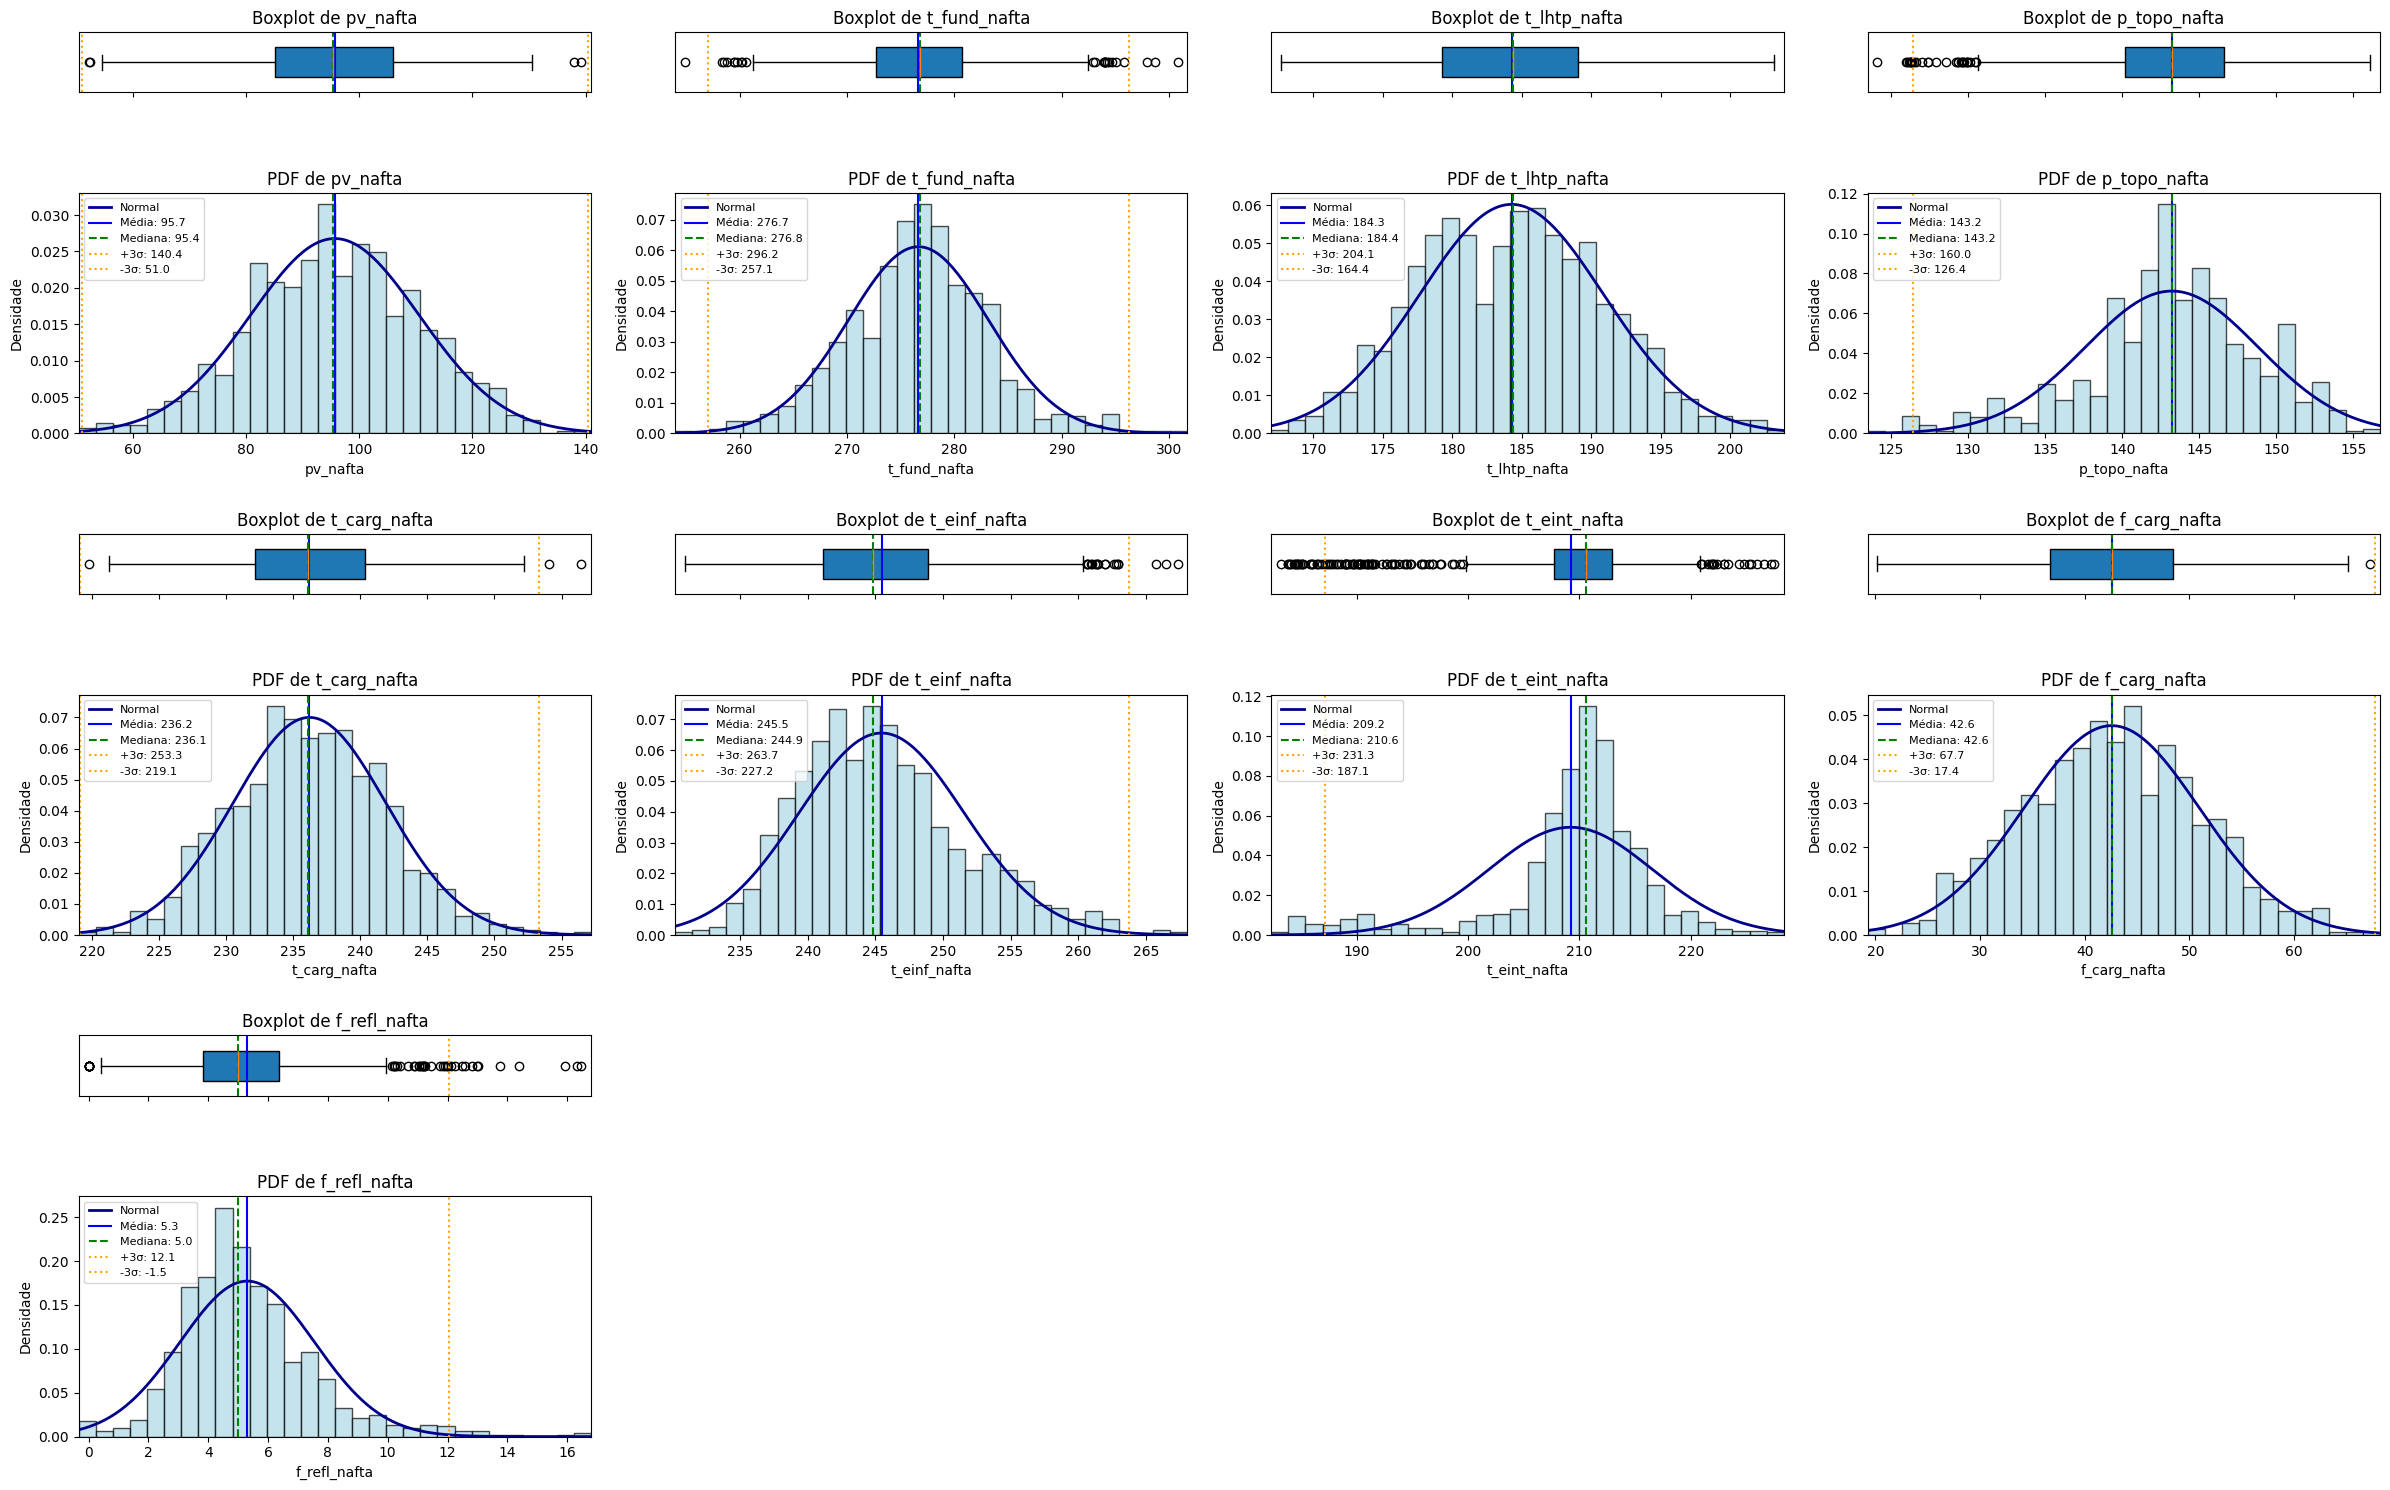

In [43]:
# Resumo das distribuições dos atributos remanescentes

plot_boxplot_pdf(df2)

### 3.3.6. Criação de novas características



Razão de refluxo: uma variável derivada, definida como a relação entre a vazão de refluxo de topo **'f_refl_nafta'** e a vazão de carga da fracionadora **'f_carg_nafta'** (**'f_refl_nafta'**/**'f_carg_nafta'**). Esta variável representa um parâmetros operacionais que pode ser críticos em fracionadoras, pois determina a eficiência da separação dos componentes.

Eficiência da separação: valores mais altos de razão de refluxo proporcionam maior contato entre as fases líquida e vapor em cada estágio do fracionamento, resultando em melhor separação dos componentes com diferentes volatilidades.

Controle da composição do produto: ao aumentar a razão de refluxo, mais componentes leves são retidos e retornam à fracionadora em vez de saírem no produto de topo, esperando-se uma elevação da pressão de vapor da nafta que sai pelo fundo da fracionadora.

Estabilidade operacional: uma razão de refluxo adequada ajuda a manter condições operacionais estáveis, reduzindo flutuações na qualidade do produto.

Perfil térmico da coluna: influencia diretamente o gradiente de temperatura ao longo da fracionadora, afetando a distribuição dos componentes em cada estágio.

Implicações: na prática, existe um trade-off importante no ajuste da razão de refluxo:

- Razão de refluxo baixa: menor consumo energético e maior capacidade de processamento, porém com qualidade de separação potencialmente comprometida.

- Razão de refluxo alta: melhor separação e controle mais preciso da pressão de vapor do produto, porém com maior consumo energético e menor capacidade de processamento.

Para a predição da pressão de vapor da nafta, a razão de refluxo representa uma variável derivada de alto valor preditivo, pois sintetiza em um único parâmetro a interação entre duas variáveis operacionais críticas que afetam diretamente o equilíbrio termodinâmico e a composição do produto final.

A inclusão desta variável no modelo preditivo provavelmente aumentará seu poder explicativo, capturando um mecanismo de controle operacional que impacta a propriedade alvo que estamos tentando prever.

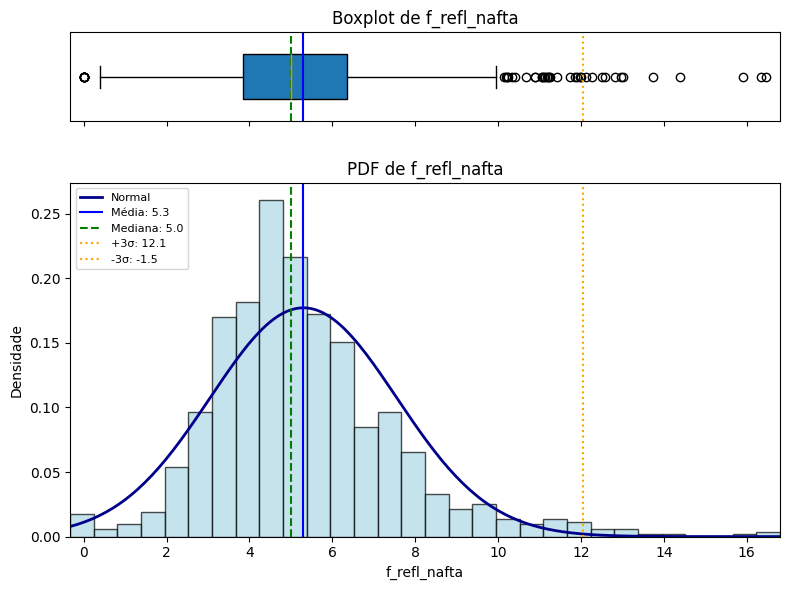

In [44]:
df2['r_refl_nafta'] = df2['f_refl_nafta'] / df2['f_carg_nafta']
plot_boxplot_pdf_indiv(df2, 'f_refl_nafta')

O novo atributo criado apresenta distribuição assimétrica à direita, com uma cauda da distribuição se estendendo nesse sentido, indicando a presença de valores mais altos menos frequentes. Esse comportamento é derivado da variável **'f_refl_nafta'** que deu origem a essa nova criação, conforme já apresentado anteriormente.

Vamos avaliar como ficaram as correlações e a VIF após essa nova vaiável.

In [45]:
calcula_vif(df2,target)
calcula_corr(df2)
# pairplot_corr_hm(df2, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)


VIF das variáveis (ordem decrescente):

Variable  r_refl_nafta  f_refl_nafta  f_carg_nafta  t_fund_nafta  t_einf_nafta  t_carg_nafta  t_lhtp_nafta  t_eint_nafta  p_topo_nafta
VIF            24.1154       18.2250        6.2141        4.4625        3.9462        3.1929        3.1915        3.0341        1.3351


É possível observar uma elevada correlação, conforme esperado, entre **'f_refl_nafta'** e a nova **'r_refl_nafta'**. Em função da relevância dessa nova variável, conforme explicado anteriormente e até mesmo da discreta maior correlação com a variável alvo, vamos suprimir a **'f_refl_nafta'** para reduzir a VIF (reduzir a mulcolinearidade).

In [46]:
df3 = df2.drop(columns=['f_refl_nafta'])
calcula_vif(df3,target)


VIF das variáveis (ordem decrescente):

Variable  t_fund_nafta  t_einf_nafta  t_carg_nafta  t_eint_nafta  t_lhtp_nafta  f_carg_nafta  r_refl_nafta  p_topo_nafta
VIF             4.4596        3.8598        3.1878        2.9373        2.9223        1.9199        1.7974        1.2920


Como a VIF ficou novamente abaixo de 5 vamos parar a remoção de variáveis nessa etapa.

# 4. Separação e divisão do dataset entre features (X) e target (y)

- Em **séries temporais**, **não embaralhe** e use divisões temporais (ex.: `TimeSeriesSplit`).
- Em **classificação desequilibrada**, considere **estratégias para desbalanceamento** (ex.: `class_weight`, undersampling/oversampling).

> **Atenção:** Todas as **transformações** aprendidas devem ser **ajustadas no treino** e **aplicadas no validação/teste**. Recomendamos usar **pipelines**.

In [47]:
# Definição do problema e inicialização de variáveis
SEED = 42
PROBLEM_TYPE = "regressao"
SPLIT = 0.2
CV_FOLDS = 5
METRIC_TO_OPTIMIZE = 'r2'

In [48]:
X = df.drop(target, axis=1)
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
)
print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Tipo:", PROBLEM_TYPE)
print("Target:", target)
print("Nº features:", X.shape[1])

Treino: (724, 11) | Teste: (182, 11)
Tipo: regressao
Target: pv_nafta
Nº features: 11


In [ ]:
# Lista de métodos de padronização
scalers = [
    # ("minmax", MinMaxScaler())
    ("standard", StandardScaler())
]

# Definição das métricas de avaliação
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'rmse': make_scorer(rmse_score, greater_is_better=False),
    'mae': 'neg_mean_absolute_error'
}

# Lista de modelos candidatos e seus hiperparâmetros para otimização
# Imports para modelos externos (se ainda não importados)
candidates = [
    ("linear",
        LinearRegression(),
        {}  # Linear Regression não tem hiperparâmetros para otimizar
    ),
    ("ridge", 
        Ridge(), {
            "regressor__alpha": Real(1e-3, 10, prior="log-uniform"),
            # Adicionados:
            "regressor__tol": Real(1e-5, 1e-3, prior="log-uniform"),
            "regressor__solver": Categorical(["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
                        }
    ),
    ("lasso", 
        Lasso(), {
            "regressor__alpha": Real(1e-5, 1, prior="log-uniform"),
            # Adicionados:
            "regressor__tol": Real(1e-5, 1e-3, prior="log-uniform"),
            "regressor__selection": Categorical(["cyclic", "random"]),
            "regressor__max_iter": Integer(1000, 3000)
                        }
    ),
    ("elasticnet", 
        ElasticNet(), {
            "regressor__alpha": Real(1e-5, 1, prior="log-uniform"),  # Aumentei o limite superior
            "regressor__l1_ratio": Real(0.01, 0.99),  # Ajustado para cobrir quase todo o intervalo
            # Adicionados:
            "regressor__tol": Real(1e-5, 1e-3, prior="log-uniform"),
            "regressor__selection": Categorical(["cyclic", "random"]),
            "regressor__max_iter": Integer(1000, 3000)
                                }
    ),
    ("randomforest", 
        RandomForestRegressor(random_state=SEED), {
            "regressor__n_estimators": Integer(50, 300),  # Reduzido o limite superior
            "regressor__max_depth": Integer(3, 25),  # Reduzido significativamente para evitar overfitting
            "regressor__min_samples_split": Integer(2, 10),  # Aumentado o limite superior
            # Adicionados:
            "regressor__min_samples_leaf": Integer(1, 10),
            "regressor__max_features": Categorical(["sqrt", "log2", None, 0.7, 0.8]),
            "regressor__bootstrap": Categorical([True, False])
                                                                }
    ),
    ("extratrees", 
        ExtraTreesRegressor(random_state=SEED), {
            "regressor__n_estimators": Integer(50, 300),  # Mantido
            "regressor__max_depth": Integer(3, 20),  # Reduzido para evitar overfitting
            "regressor__min_samples_split": Integer(2, 10),  # Aumentado o limite superior
            # Adicionados:
            "regressor__min_samples_leaf": Integer(1, 10),
            "regressor__max_features": Categorical(["sqrt", "log2", None, 0.7, 0.8]),
            "regressor__bootstrap": Categorical([True, False])
                                                            }
    ),
    ("gbr", 
        GradientBoostingRegressor(random_state=SEED), {
            "regressor__n_estimators": Integer(50, 200),  # Mantido
            "regressor__learning_rate": Real(0.01, 0.3, prior="log-uniform"),  # Ajustado o intervalo
            "regressor__max_depth": Integer(2, 8),  # Aumentado ligeiramente o limite superior
            # Adicionados:
            "regressor__min_samples_split": Integer(2, 20),
            "regressor__min_samples_leaf": Integer(1, 10),
            "regressor__subsample": Real(0.6, 1.0),
            "regressor__max_features": Categorical(["sqrt", "log2", None])
                                                            }
    ),
    ("xgboost", 
        XGBRegressor(random_state=SEED, verbosity=0), {
            "regressor__n_estimators": Integer(50, 300),  # Mantido
            "regressor__learning_rate": Real(0.01, 0.3, prior="log-uniform"),  # Ajustado o intervalo
            "regressor__max_depth": Integer(3, 12),  # Reduzido significativamente
            "regressor__subsample": Real(0.6, 1.0),  # Ajustado o limite inferior
            "regressor__colsample_bytree": Real(0.6, 1.0),  # Ajustado o limite inferior
            # Adicionados:
            "regressor__min_child_weight": Integer(1, 10),
            "regressor__gamma": Real(0, 5),
            "regressor__reg_alpha": Real(0, 2),
            "regressor__reg_lambda": Real(0.5, 5),
            # "regressor__early_stopping_rounds": Categorical([10, 20, 50])
                                                            }
    ),
    ("lightgbm", 
        LGBMRegressor(random_state=SEED, force_col_wise=True, min_split_gain=0.1, verbose=-1), {
            "regressor__n_estimators": Integer(100, 500),  # Ajustado o limite inferior
            "regressor__learning_rate": Real(0.01, 0.3, prior="log-uniform"),  # Ajustado o intervalo
            "regressor__max_depth": Integer(3, 15),  # Reduzido
            "regressor__num_leaves": Integer(20, 100),  # Reduzido significativamente
            # Adicionados:
            "regressor__min_child_samples": Integer(5, 50),
            "regressor__reg_alpha": Real(0, 2),
            "regressor__reg_lambda": Real(0.5, 5),
            "regressor__subsample": Real(0.6, 1.0),
            "regressor__colsample_bytree": Real(0.6, 1.0),
            "regressor__bagging_freq": Integer(0, 10)
                                                                                                        }
    ),
    ("catboost", 
        CatBoostRegressor(random_state=SEED, verbose=0), {
            "regressor__iterations": Integer(100, 800),  # Reduzido
            "regressor__learning_rate": Real(0.01, 0.3, prior="log-uniform"),  # Ajustado o intervalo
            "regressor__depth": Integer(4, 10),  # Reduzido
            # Adicionados:
            "regressor__l2_leaf_reg": Real(1, 10),
            "regressor__subsample": Real(0.6, 1.0),
            "regressor__rsm": Real(0.6, 1.0),  # Column subsample ratio
            "regressor__min_data_in_leaf": Integer(1, 20),
            "regressor__border_count": Integer(32, 255)
                                                                }
    ),
   ("svr", 
        SVR(), {
            "regressor__C": Real(0.1, 100, prior="log-uniform"),  # Reduzido o intervalo
            "regressor__epsilon": Real(0.01, 1.0, prior="log-uniform"),  # Reduzido significativamente
            "regressor__kernel": Categorical(["rbf", "linear", "poly"]),  # Adicionado kernel polinomial
            # Adicionados:
            "regressor__gamma": Real(0.001, 1.0, prior="log-uniform"),  # Importante para kernel RBF
            "regressor__degree": Integer(2, 4),  # Para kernel polinomial
            "regressor__coef0": Real(0, 1)  # Para kernel polinomial
                }
    )
]

In [50]:
# Modelo baseline
baseline_algorithm = candidates[0]

# Agora você pode acessar facilmente:
print(f"Baseline model: {baseline_algorithm[0]} - {baseline_algorithm[1]}")
print(f"Total de candidatos (incluindo baseline): {len(candidates)}")

# Verificar a estrutura
for i, (name, model, params) in enumerate(candidates):
    print(f"candidates[{i}]: {name}")

Baseline model: linear - LinearRegression()
Total de candidatos (incluindo baseline): 4
candidates[0]: linear
candidates[1]: xgboost
candidates[2]: lightgbm
candidates[3]: svr


In [51]:
# Pegar o baseline (primeiro elemento da lista candidates)
baseline_name, baseline_model, _ = baseline_algorithm

print("="*80)
print(f"BASELINE - {baseline_name.upper()}: {baseline_model}")
print("="*80)

# Loop através de todas as configurações de scaler da lista scalers
for scaler_name, scaler in scalers:
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', baseline_model)
    ])

    # Validação cruzada
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=CV_FOLDS,
        scoring=scoring,
        return_train_score=True
    )

    # Adicionar resultados ao DataFrame unificado
    all_results_df = add_results_to_df(
        all_results_df,
        model_name=baseline_name,  # Usar o nome do candidates[0]
        scaler_name=scaler_name,
        cv_results=cv_results,
        hyperparams='default',
        optimization_method='baseline'
    )

    print_metrics_table(baseline_name, scaler_name, cv_results)

# Filtrar resultados do baseline
baseline_results = all_results_df[
    (all_results_df['model_name'] == baseline_name) & 
    (all_results_df['optimization_method'] == 'baseline')
].copy()

# Melhor configuração
best_baseline = baseline_results.loc[baseline_results['r2_cv_mean'].idxmax()]
print(f"\nMelhor configuração baseline {baseline_name}:")
print(f"- Scaler: {best_baseline['scaler']}")
print(f"- R² CV: {best_baseline['r2_train_mean']:.4f}")
print(f"- R² CV: {best_baseline['r2_cv_mean']:.4f}")
print(f"- RMSE CV: {best_baseline['rmse_train_mean']:.4f}")
print(f"- RMSE CV: {best_baseline['rmse_cv_mean']:.4f}")
print(f"- Data do experimento: {best_baseline['experiment_date']}")

BASELINE - LINEAR: LinearRegression()

Modelo: LINEAR com Scaler: standard
+-----------+---------------------------+-----------------------+
| Métrica   | Treino (média ± desvio)   | CV (média ± desvio)   |
+===========+===========================+=======================+
| R²        | 0.7620 (±0.0076)          | 0.7510 (±0.0291)      |
+-----------+---------------------------+-----------------------+
| RMSE      | 7.2980 (±0.1157)          | 7.4255 (±0.4432)      |
+-----------+---------------------------+-----------------------+

Melhor configuração baseline linear:
- Scaler: standard
- R² CV: 0.7620
- R² CV: 0.7510
- RMSE CV: 7.2980
- RMSE CV: 7.4255
- Data do experimento: 2025-09-01 18:20:38


In [52]:
# # Loop através dos outros candidatos (excluindo o baseline)
# other_candidates = [candidate for candidate in candidates if candidate[0] != baseline_name]

# print("Iniciando avaliação dos modelos candidatos...")


# # Loop através de cada modelo candidato
# for model_name, model, _ in other_candidates:

#     # Cria o pipeline com o scaler e o modelo
#     pipeline = Pipeline([
#         ('scaler', scaler),
#         ('regressor', clone(model))  # Usar clone para garantir que o modelo seja resetado a cada iteração
#     ])

#     # Validação cruzada
#     cv_results = cross_validate(
#         pipeline, X_train, y_train,
#         cv=CV_FOLDS,
#         scoring=scoring,
#         return_train_score=True,
#         n_jobs=-1 # Utiliza todos os processadores para acelerar
#     )

#     # Adicionar resultados ao DataFrame unificado
#     all_results_df = add_results_to_df(
#         all_results_df,
#         model_name=model_name,
#         scaler_name=scaler_name,
#         cv_results=cv_results,
#         hyperparams='default',
#         optimization_method='baseline' # Ainda estamos na fase de baseline para estes modelos
#     )

# print("="*80)
# print("Cálculos concluídos.")

In [53]:
# # Loop para EXIBIR os resultados a partir do DataFrame
# for model_name, _, _ in other_candidates:
    
#     # Filtra o DataFrame para o modelo atual
#     model_results_df = all_results_df[
#         (all_results_df['model_name'] == model_name) &
#         (all_results_df['optimization_method'] == 'baseline')
#     ]



# # Exibir um resumo dos melhores resultados encontrados até agora
# display_results_summary(all_results_df, top_n=len(candidates), metric='r2_cv_mean')

In [55]:
# --- Célula de Otimização de Hiperparâmetros com BayesSearchCV ---
# Parâmetros para a Otimização Bayesiana
N_ITER_BAYES = 3  # Número de iterações da busca. Aumentar para uma busca mais exaustiva.


# Dicionário para armazenar os resultados detalhados dos folds para o boxplot
boxplot_data = []

print("="*100)
print(f"Iniciando Otimização Bayesiana de Hiperparâmetros (n_iter={N_ITER_BAYES})")
print(f"Métrica de otimização: {METRIC_TO_OPTIMIZE}")
print("="*100)

# Loop através dos candidatos e scalers
# for scaler_name, scaler in scalers:
for model_name, model, params in candidates:
    # Pula modelos que não têm hiperparâmetros para otimizar
    if not params:
        print(f"\n--- Modelo '{model_name.upper()}' sem hiperparâmetros para otimizar. Pulando. ---")
        continue
    
    start_time = time.time()
    print(f"\nOtimizando: {model_name.upper()} com Scaler: {scaler_name}...")
    
    # 1. Cria o pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', clone(model))
    ])
    
    # 2. Configura o BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=params,
        n_iter=N_ITER_BAYES,
        cv=KFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED),
        scoring=scoring,  # Passa o dicionário completo de métricas
        refit=METRIC_TO_OPTIMIZE, # Informa qual métrica usar para encontrar o melhor modelo
        n_jobs=-1,
        verbose=0,
        random_state=SEED,
        return_train_score=True
    )
    
    # 3. Preparar early stopping se o modelo suportar
    fit_params, X_train_fit, y_train_fit = prepare_early_stopping_params(model_name, X_train, y_train)
    
    # 4. Configurar o callback para monitoramento
    monitor = MetricsMonitorCallback(
        model_name=model_name, 
        scaler_name=scaler_name,
        metric=METRIC_TO_OPTIMIZE,
        threshold=0.2,  # 20% de diferença é considerado overfitting
        plot_interval=5,  # Plotar a cada 5 iterações
        plot_dir='optimization_plots'  # Diretório para salvar os gráficos
    )

    # Anexa o objeto BayesSearchCV ao callback para que ele possa acessar cv_results_ durante a busca
    monitor.bayes_search = bayes_search

    # 5. Executa a busca com o callback e early stopping
    try:
        # 5. Executa a busca com o callback
        # bayes_search.fit(X_train, y_train, callback=[monitor], **fit_params)
        bayes_search.fit(X_train, y_train, callback=[monitor])
        
        # 6. Finalizar o callback para acessar os resultados completos
        monitor.finalize()
        
    except Exception as e:
        print(f"Erro durante a otimização: {str(e)}")
    
    # 7. Retornar o melhor modelo e seus parâmetros
    best_params = bayes_search.best_params_
    best_score = bayes_search.best_score_
    best_model = bayes_search.best_estimator_
    
    print(f"\nMelhor {model_name} + {scaler_name}:")
    print(f"Melhor score ({METRIC_TO_OPTIMIZE}): {best_score:.4f}")
    print(f"Melhores parâmetros: {best_params}")
    
    end_time = time.time()
    print(f"Otimização concluída em {end_time - start_time:.2f} segundos.")
    print(f"Melhor {METRIC_TO_OPTIMIZE} (CV): {bayes_search.best_score_:.4f}")
    print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
    print(f'N. Iterações: {bayes_search.n_iter}')
    
    # # Visualizar a importância de cada parâmetro
    # try:
    #     _ = plot_objective(bayes_search.optimizer_results_[0], size=3, n_points=15)
    #     plt.tight_layout()
    #     plt.show()
    # except Exception as e:
    #     print(f"Erro ao plotar objetivos: {e}")
    
    # 6. Adiciona os resultados ao DataFrame principal
    # O BayesSearchCV não retorna todas as métricas no cv_results, então criamos um dict compatível
    best_index = bayes_search.best_index_
    cv_results_for_df = {
        'train_r2': bayes_search.cv_results_['mean_train_r2'],
        'test_r2': bayes_search.cv_results_['mean_test_r2'],
        'train_rmse': bayes_search.cv_results_['mean_train_rmse'],
        'test_rmse': bayes_search.cv_results_['mean_test_rmse'],
        'train_mse': bayes_search.cv_results_['mean_train_mse'],
        'test_mse': bayes_search.cv_results_['mean_test_mse'],
        'train_mae': bayes_search.cv_results_['mean_train_mae'],
        'test_mae': bayes_search.cv_results_['mean_test_mae'],
        'fit_time': bayes_search.cv_results_['mean_fit_time'],
        'score_time': bayes_search.cv_results_['mean_score_time']
    }
    
    # O scikit-learn retorna um array para cada métrica, então pegamos o valor do melhor índice
    for key in cv_results_for_df:
        if key not in ['fit_time', 'score_time']:
                cv_results_for_df[key] = np.array([cv_results_for_df[key][best_index]])
    
    all_results_df = add_results_to_df(
        all_results_df,
        model_name=model_name,
        scaler_name=scaler_name,
        cv_results=cv_results_for_df,
        hyperparams=bayes_search.best_params_,
        optimization_method='bayes_search'
    )
    
    # 7. Guarda os dados dos folds (treino e teste) para o boxplot
    for fold_idx in range(CV_FOLDS):
        boxplot_data.append({
            'model_name': model_name,
            'scaler': scaler_name,
            'type': 'Train',
            f'{METRIC_TO_OPTIMIZE}_score': bayes_search.cv_results_[f'split{fold_idx}_train_{METRIC_TO_OPTIMIZE}'][best_index]
        })
        boxplot_data.append({
            'model_name': model_name,
            'scaler': scaler_name,
            'type': 'Test (CV)',
            f'{METRIC_TO_OPTIMIZE}_score': bayes_search.cv_results_[f'split{fold_idx}_test_{METRIC_TO_OPTIMIZE}'][best_index]
        })

print("\n" + "="*100)
print("TODAS AS OTIMIZAÇÕES FORAM CONCLUÍDAS.")
print("="*100)


Iniciando Otimização Bayesiana de Hiperparâmetros (n_iter=3)
Métrica de otimização: r2

--- Modelo 'LINEAR' sem hiperparâmetros para otimizar. Pulando. ---

Otimizando: XGBOOST com Scaler: standard...

Iteração 1: xgboost + standard
   Validação estimada r2: 0.7772

Iteração 2: xgboost + standard
   Validação estimada r2: 0.7148

Iteração 3: xgboost + standard
   Validação estimada r2: 0.7208

⚠️ ALERTA: Possível overfitting detectado na iteração 1!
   Treino: 0.9949, Validação: 0.7772, Diferença: 0.2177

Melhor xgboost + standard:
Melhor score (r2): 0.7772
Melhores parâmetros: OrderedDict([('regressor__colsample_bytree', 0.7640415835413256), ('regressor__gamma', 3.6386287158866253), ('regressor__learning_rate', 0.2387586688716479), ('regressor__max_depth', 6), ('regressor__min_child_weight', 7), ('regressor__n_estimators', 154), ('regressor__reg_alpha', 0.701862669798288), ('regressor__reg_lambda', 3.8277690538568923), ('regressor__subsample', 0.7217853244146024)])
Otimização concluíd

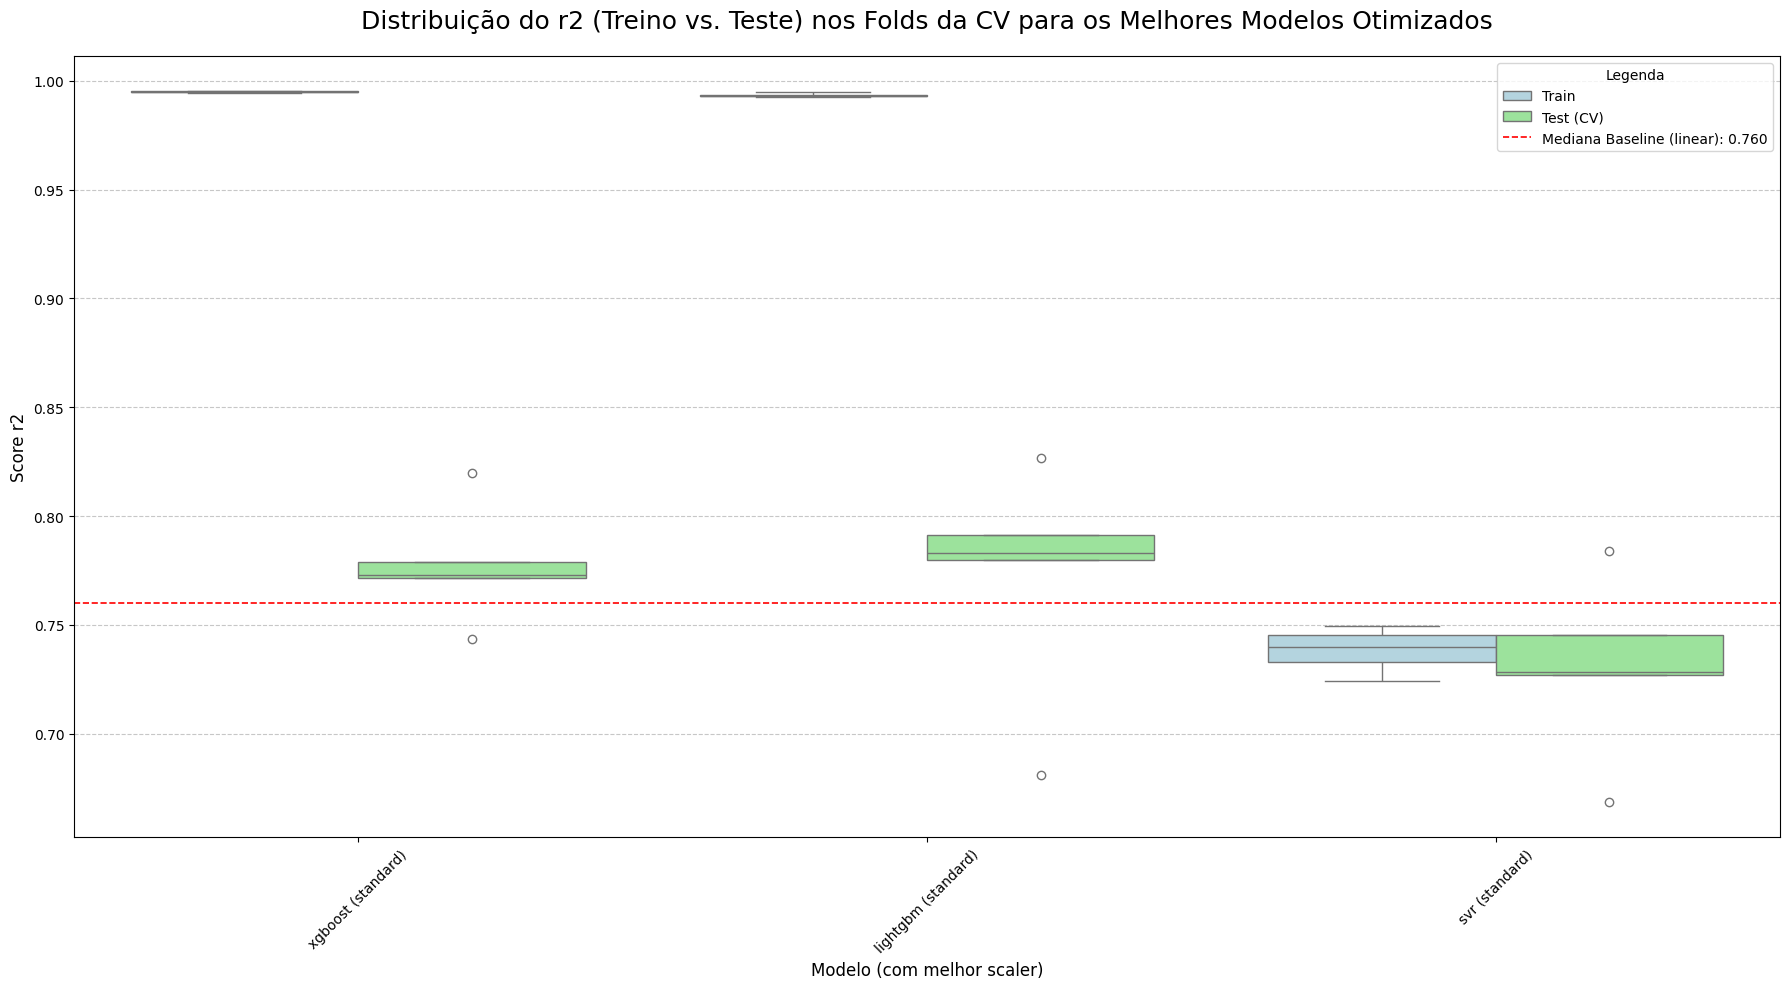


Resumo Geral dos Melhores Modelos (Incluindo Baseline e Otimizados)

TOP 15 MODELOS - Ordenados por R2_CV_MEAN
model_name   scaler optimization_method  r2_train_mean  r2_cv_mean  rmse_train_mean  rmse_cv_mean  fit_time_mean
   xgboost standard        bayes_search         0.9949      0.7772           1.0671        7.0285         0.3067
   xgboost standard        bayes_search         0.9949      0.7772           1.0671        7.0285         0.3440
  lightgbm standard        bayes_search         0.9933      0.7723           1.2237        7.0710         4.0647
    linear standard            baseline         0.7620      0.7510           7.2980        7.4255         0.0000
       svr standard        bayes_search         0.7383      0.7307           7.6531        7.7197         0.0251

ESTATÍSTICAS GERAIS:
Total de experimentos: 5
Modelos únicos testados: 4
Scalers testados: 1
Métodos de otimização: 2

Melhor resultado:
- Modelo: xgboost
- Scaler: standard
- Método: bayes_search
- r2_cv_mean

In [56]:
# --- Célula de Visualização dos Resultados da Otimização ---

# Criar um DataFrame a partir dos dados do boxplot
boxplot_df = pd.DataFrame(boxplot_data)

bayes_results_df = all_results_df[all_results_df['optimization_method'] == 'bayes_search'].copy()

# Filtrar apenas os melhores resultados de cada modelo (melhor scaler)
best_optimized_models = bayes_results_df.loc[
    bayes_results_df.groupby('model_name')[f'{METRIC_TO_OPTIMIZE}_cv_mean'].idxmax()
]

# Criar uma lista com os nomes dos melhores modelos e seus scalers para o filtro
best_model_scaler_pairs = list(zip(best_optimized_models['model_name'], best_optimized_models['scaler']))

# Filtrar o boxplot_df para conter apenas os melhores
best_boxplot_df = boxplot_df[
    boxplot_df.apply(lambda row: (row['model_name'], row['scaler']) in best_model_scaler_pairs, axis=1)
].copy()

# Adicionar uma coluna de identificação para o plot
best_boxplot_df['model_id'] = best_boxplot_df['model_name'] + ' (' + best_boxplot_df['scaler'] + ')'

# --- Cálculo da Mediana do Baseline ---
# Identificar o melhor scaler para o modelo baseline
baseline_name = baseline_algorithm[0]
baseline_model = baseline_algorithm[1]
baseline_results = all_results_df[
    (all_results_df['model_name'] == baseline_name) &
    (all_results_df['optimization_method'] == 'baseline')
]
best_baseline_config = baseline_results.loc[baseline_results[f'{METRIC_TO_OPTIMIZE}_cv_mean'].idxmax()]
best_scaler_name = best_baseline_config['scaler']
best_scaler_obj = dict(scalers)[best_scaler_name]

# Recalcular a validação cruzada para o melhor baseline para obter os scores dos folds
baseline_pipeline = Pipeline([('scaler', best_scaler_obj), ('regressor', baseline_model)])
baseline_cv_scores = cross_validate(
    baseline_pipeline, X_train, y_train, cv=CV_FOLDS, scoring=METRIC_TO_OPTIMIZE
)['test_score']

# Calcular a mediana dos scores
baseline_median_score = np.median(baseline_cv_scores)

# Plotar o boxplot
#plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

sns.boxplot(
    data=best_boxplot_df,
    x='model_id',
    y=f'{METRIC_TO_OPTIMIZE}_score',
    hue='type',
    ax=ax,
    palette={'Train': 'lightblue', 'Test (CV)': 'lightgreen'} # Paleta ajustada
)

ax.set_title(f'Distribuição do {METRIC_TO_OPTIMIZE} (Treino vs. Teste) nos Folds da CV para os Melhores Modelos Otimizados', fontsize=18, pad=20)
ax.set_xlabel('Modelo (com melhor scaler)', fontsize=12)
ax.set_ylabel(f'Score {METRIC_TO_OPTIMIZE}', fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title='Tipo de Score', fontsize=10)
ax.axhline(baseline_median_score, color='red', linestyle='--', linewidth=1.2, label=f'Mediana Baseline ({baseline_name}): {baseline_median_score:.3f}')
ax.grid(axis='y', linestyle='--', alpha=0.7) # Adicionado grid para melhor visualização
# ax.yaxis.grid(True)

# Atualiza a legenda para incluir a linha do baseline
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Legenda', fontsize=10)

plt.tight_layout()
plt.show()

# Exibir o resumo dos melhores modelos, incluindo os otimizados
print("\n" + "="*100)
print("Resumo Geral dos Melhores Modelos (Incluindo Baseline e Otimizados)")
print("="*100)
display_results_summary(all_results_df, top_n=15, metric=f'{METRIC_TO_OPTIMIZE}_cv_mean')
display_results_summary_median(
    summary_df=all_results_df,
    fold_scores_df=boxplot_df,
    top_n=15,
    metric=METRIC_TO_OPTIMIZE
)

In [ ]:
import joblib

print("Melhores hiperparâmetros encontrados:")
print(bayes_search.best_params_)

# Salvar o melhor modelo treinado (pipeline) em um arquivo
best_model_filename = 'melhor_modelo_otimizado.joblib'
joblib.dump(bayes_search.best_estimator_, best_model_filename)
print(f"Melhor modelo otimizado salvo em '{best_model_filename}'.")

In [ ]:
# --- Avaliação do Melhor Modelo no Conjunto de Teste (Dados Não Vistos) ---

# 1. O `best_estimator_` do BayesSearchCV é o pipeline já treinado com os melhores parâmetros
#    encontrados na última busca. Vamos usá-lo para prever nos dados de teste.
#    Nota: Isso usa o melhor estimador da ÚLTIMA busca no loop (neste caso, SVR).
#    Se o melhor modelo geral for outro, o processo seria um pouco diferente.
best_model_final = bayes_search.best_estimator_

# 2. Fazer previsões no conjunto de teste
y_pred_test = best_model_final.predict(X_test)

# 3. Calcular as métricas de avaliação
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# 4. Exibir os resultados
print("="*80)
print(f"Resultados do Melhor Modelo no Conjunto de Teste (X_test)")
# Extrai o nome do modelo do pipeline para exibição
model_name_in_pipeline = best_model_final.named_steps['regressor'].__class__.__name__
print(f"Modelo: {model_name_in_pipeline}")
print("="*80)

metrics_data = [
    ["R² (R-squared)", f"{r2_test:.4f}"],
    ["MSE (Mean Squared Error)", f"{mse_test:.4f}"],
    ["RMSE (Root Mean Squared Error)", f"{rmse_test:.4f}"],
    ["MAE (Mean Absolute Error)", f"{mae_test:.4f}"]
]
headers = ["Métrica", "Valor no Conjunto de Teste"]

print(tabulate(metrics_data, headers=headers, tablefmt="grid"))
print("="*80)

In [ ]:
import ast

# --- Retreinamento do Melhor Modelo com Todos os Dados ---

print("="*80)
print("Retreinando o melhor modelo com o dataset completo (X, y)")
print("="*80)

# 1. Identificar o melhor modelo geral a partir dos resultados
best_model_info = all_results_df.loc[all_results_df['r2_cv_mean'].idxmax()]

best_model_name = best_model_info['model_name']
best_scaler_name = best_model_info['scaler']
best_params_str = best_model_info['hyperparams']

# Converter a string de hiperparâmetros de volta para um dicionário
# Usar ast.literal_eval é mais seguro do que eval()
try:
    best_params = ast.literal_eval(best_params_str)
except (ValueError, SyntaxError):
    best_params = {} # Caso os hiperparâmetros sejam 'default' ou algo não-dicionário

# 2. Encontrar os objetos originais do modelo e do scaler
model_obj = None
for name, model, _ in candidates:
    if name == best_model_name:
        model_obj = clone(model)
        break

scaler_obj = None
for name, scaler in scalers:
    if name == best_scaler_name:
        scaler_obj = scaler
        break

if model_obj is None or scaler_obj is None:
    print("Erro: Não foi possível encontrar o modelo ou scaler correspondente.")
else:
    # 3. Criar o pipeline final
    final_pipeline = Pipeline([
        ('scaler', scaler_obj),
        ('regressor', model_obj)
    ])

    # 4. Definir os melhores hiperparâmetros no pipeline
    # Adiciona o prefixo 'regressor__' se não estiver presente
    final_params = {}
    for key, value in best_params.items():
        if not key.startswith('regressor__'):
            final_params[f'regressor__{key}'] = value
        else:
            final_params[key] = value
            
    final_pipeline.set_params(**final_params)

    # 5. Retreinar o pipeline com todos os dados (X e y)
    print(f"Modelo selecionado: {best_model_name.upper()}")
    print(f"Scaler: {best_scaler_name}")
    print(f"Hiperparâmetros: {best_params}")
    
    start_fit_time = time.time()
    final_pipeline.fit(X, y)
    end_fit_time = time.time()
    
    print(f"\nTreinamento com dados completos concluído em {end_fit_time - start_fit_time:.2f} segundos.")

    # 6. Fazer previsões nos próprios dados de treinamento para avaliar o ajuste
    y_pred_full = final_pipeline.predict(X)

    # 7. Calcular e exibir as métricas de desempenho no conjunto de dados completo
    r2_full = r2_score(y, y_pred_full)
    mse_full = mean_squared_error(y, y_pred_full)
    rmse_full = np.sqrt(mse_full)
    mae_full = mean_absolute_error(y, y_pred_full)

    print("\n" + "="*80)
    print("Métricas do Modelo Final (avaliadas no dataset completo)")
    
    full_metrics_data = [
        ["R² (R-squared)", f"{r2_full:.4f}"],
        ["MSE (Mean Squared Error)", f"{mse_full:.4f}"],
        ["RMSE (Root Mean Squared Error)", f"{rmse_full:.4f}"],
        ["MAE (Mean Absolute Error)", f"{mae_full:.4f}"]
    ]
    headers_full = ["Métrica", "Valor no Dataset Completo"]

    print(tabulate(full_metrics_data, headers=headers_full, tablefmt="grid"))
    print("="*80)

In [ ]:


# --- Gráficos de Análise do Modelo Final ---

# 1. Calcular o erro
prediction_error = y - y_pred_full

# 2. Criar os subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=(
        "Tendência do Erro de Predição (Real - Previsto)",
        "Comparativo: Valores Reais vs. Valores Previstos"
    )
)

# --- Gráfico 1: Tendência do Erro ---
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=prediction_error,
        mode='lines',
        name='Erro',
        line=dict(color='indianred')
    ),
    row=1, col=1
)
# Adiciona uma linha em y=0 para referência de erro nulo
fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=1)

# --- Gráfico 2: Real vs. Previsto ---
# Adiciona a linha dos valores reais
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y,
        mode='lines',
        name='Valor Real',
        line=dict(color='royalblue')
    ),
    row=2, col=1
)
# Adiciona a linha dos valores previstos
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y_pred_full,
        mode='lines',
        name='Valor Previsto',
        line=dict(color='darkorange', dash='dot')
    ),
    row=2, col=1
)

# 3. Atualizar o layout geral
fig.update_layout(
    height=700,
    title_text="Análise Gráfica do Desempenho do Modelo Final no Dataset Completo",
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Atualizar os títulos dos eixos
fig.update_yaxes(title_text="Erro (Real - Previsto)", row=1, col=1)
fig.update_yaxes(title_text="Valor da Variável Target", row=2, col=1)
fig.update_xaxes(title_text="Índice da Amostra", row=2, col=1)


fig.show()

In [ ]:
# --- Salvando e Carregando o Modelo Final ---

# 1. Definir o nome do arquivo para salvar o modelo
model_filename = 'modelo_final_pv_nafta.joblib'

# 2. Salvar o pipeline treinado em um arquivo
print("="*80)
print(f"Salvando o modelo final em '{model_filename}'...")
joblib.dump(final_pipeline, model_filename)
print("Modelo salvo com sucesso!")
print("="*80)


# --- Demonstração de Carregamento e Uso ---

# 3. Carregar o modelo a partir do arquivo
print("\nCarregando o modelo para demonstração...")
loaded_model = joblib.load(model_filename)
print("Modelo carregado com sucesso.")

# 4. Usar o modelo carregado para fazer uma predição em um novo dado
#    (usaremos a primeira linha do dataset X como exemplo)
sample_data = X.head(1)
prediction = loaded_model.predict(sample_data)

print("\n" + "="*80)
print("Exemplo de predição com o modelo carregado:")
print(f"Dados de entrada (primeira linha do dataset):\n{sample_data.to_string()}")
print(f"\nValor Predito: {prediction[0]:.4f}")
print("="*80)

# Conclusão

O presente estudo demonstrou a importância de um processo rigoroso de análise exploratória, tratamento e pré-processamento dos dados para problemas de regressão em ambientes industriais. A partir do dataset de Pressão de Vapor da Nafta, foi possível identificar, tratar e justificar a remoção de outliers, realizar imputação de valores faltantes, criar variáveis derivadas relevantes (como a razão de refluxo), além de aplicar técnicas de transformação para redução de assimetrias e multicolinearidade.

A análise estatística e visual das variáveis, aliada ao conhecimento de domínio, permitiu selecionar os atributos mais representativos para a modelagem preditiva, reduzindo redundâncias e otimizando o conjunto de dados para futuros algoritmos de machine learning. As etapas de normalização e padronização garantiram que as diferentes escalas das variáveis não influenciassem indevidamente o desempenho dos modelos.

